In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
import sys
import os
import warnings

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from datetime import timedelta
from lightgbm import LGBMRegressor

warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


c:\Users\andre\miniconda3\envs\crypto-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading meme data

In [3]:
data = pd.read_csv('../data/processed/gaming.csv')

print(data.shape)
data.head()

(125654, 10)


timestamp      open      high       low     close        volume    name  \
0  1639526400  4.744375  5.317031  2.173027  3.078208  1.480910e+06  SENATE   
1  1639612800  3.090095  3.299374  2.405868  2.605501  6.657927e+05  SENATE   
2  1639699200  2.625207  3.096436  2.283871  2.741340  5.401045e+05  SENATE   
3  1639785600  2.771380  3.038297  2.604262  2.720898  2.294669e+05  SENATE   
4  1639872000  2.726673  2.815944  2.498097  2.724654  1.654344e+05  SENATE   

   symbol                                    id category  
0  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
1  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
2  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
3  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
4  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125654 entries, 0 to 125653
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  125654 non-null  int64  
 1   open       125654 non-null  float64
 2   high       125654 non-null  float64
 3   low        125654 non-null  float64
 4   close      125654 non-null  float64
 5   volume     125654 non-null  float64
 6   name       125654 non-null  object 
 7   symbol     125654 non-null  object 
 8   id         125654 non-null  object 
 9   category   125654 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 9.6+ MB


## Preprocessing data

In [5]:
def removing_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    duplicates = pd.read_csv('../data/raw/duplicates.csv')
    for index, row in duplicates.iterrows():
        id = row['id']
        category = row['category']
        df = df[~((df['id'] == id) & (df['category'] == category))]
    return df

In [6]:
data_cleaned = removing_duplicates(data)

### Capping time series

Capping the first timestamp of each token with the most common one in order to avoid error when predicting.

In [7]:
def capping_time_series(df: pd.DataFrame) -> pd.DataFrame:
    token_info = df.groupby('id')['name'].value_counts()
    mean = np.floor(token_info.mean()).astype(int)
    ids_to_keep = token_info[token_info > 365].index.get_level_values(0).unique()
    filtered_meme = df[df['id'].isin(ids_to_keep)]
    first_timestamps = filtered_meme.groupby('id').timestamp.min()
    last_timestamps = filtered_meme.groupby('id').timestamp.max()
    max_first_timestamp = first_timestamps.max()
    min_last_timestamp = last_timestamps.min()
    return filtered_meme[filtered_meme['timestamp'] <= min_last_timestamp]

In [8]:
data_capped = capping_time_series(data_cleaned)

In [9]:
# check how many tokens left
tokens = data_cleaned.groupby('id')['name'].value_counts()
tokens.describe()

count     103.000000
mean     1045.097087
std       560.569677
min       100.000000
25%       813.500000
50%      1078.000000
75%      1252.000000
max      3022.000000
Name: count, dtype: float64

In [10]:
def timestamp_to_datetime(df: pd.DataFrame) -> pd.DataFrame:
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

In [11]:
data_datetime = timestamp_to_datetime(data_capped)

In [12]:
# reset the index
data_datetime.reset_index(drop=True, inplace=True)
data_datetime.head()

timestamp      open      high       low     close       volume  \
0 2022-06-18  0.063849  0.064373  0.063849  0.064100  3097.913445   
1 2022-06-19  0.062489  0.062665  0.062130  0.062665  2388.142548   
2 2022-06-20  0.062719  0.062724  0.062719  0.062724   806.335986   
3 2022-06-21  0.067348  0.067348  0.065770  0.065770  9486.514007   
4 2022-06-22  0.068548  0.068548  0.068520  0.068520    69.936620   

             name symbol                                    id category  
0  Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   gaming  
1  Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   gaming  
2  Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   gaming  
3  Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   gaming  
4  Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   gaming

### Scaling

In [13]:
def scaling(df: pd.DataFrame) -> pd.DataFrame:
    series_scaler = StandardScaler()
    exog_scaler = StandardScaler()
    halving_dates = [pd.to_datetime('2012-11-28'), pd.to_datetime('2016-07-09'), pd.to_datetime('2020-05-11'), pd.to_datetime('2024-04-20'), pd.to_datetime('2028-03-28')]
    df['days_until_halving'] = df['timestamp'].apply(lambda x: min([(halving - x).days for halving in halving_dates if halving > x]) if any(halving > x for halving in halving_dates) else 0).astype('float64')
    df['close'] = series_scaler.fit_transform(df[['close']])
    df['days_until_halving'] = exog_scaler.fit_transform(df[['days_until_halving']])
    return df, series_scaler, exog_scaler

In [14]:
data_final, series_scaler, exog_scaler = scaling(data_datetime)

In [15]:
# SHOW NUMBER UNIQUE TOKENS
data_final['id'].nunique()

88

In [16]:
# create a function to plot the time series of each token in a loop
def plot_time_series(df: pd.DataFrame, n: int) -> None:
    ids = df['id'].unique()
    for i in range(n):
        id = ids[i]
        token = df[df['id'] == id]
        plt.figure(figsize=(15, 5))
        plt.plot(token['timestamp'], token['close'])
        plt.title(f'Token ID: {id}')
        plt.show()

In [17]:
# plot_time_series(meme, 20)

In [18]:
def create_series_exog(df: pd.DataFrame) -> pd.DataFrame:
    data_copy = df.copy()
    data_copy['seconds'] = data_copy['timestamp'].apply(lambda x: x.timestamp())
    
    day = 60 * 60 * 24
    week = day * 7
    month = week * 4

    data_copy['week_sin'] = np.sin(data_copy['seconds'] * (2 * np.pi / week))
    data_copy['week_cos'] = np.cos(data_copy['seconds'] * (2 * np.pi / week))
    data_copy['month_sin'] = np.sin(data_copy['seconds'] * (2 * np.pi / month))
    data_copy['month_cos'] = np.cos(data_copy['seconds'] * (2 * np.pi / month))

    series = data_copy[['timestamp', 'id', 'close']]
    exog = data_copy[['timestamp', 'id', 'days_until_halving']]
    return series, exog

def create_future_exog(df: pd.DataFrame, days: int = 60) -> pd.DataFrame:
    last_timestamp = df['timestamp'].max()
    future_dates = pd.date_range(start=last_timestamp + timedelta(days=1), periods=days, freq='D')
    
    future_data = pd.DataFrame({'timestamp': future_dates})
    future_data['seconds'] = future_data['timestamp'].apply(lambda x: x.timestamp())

    day = 60 * 60 * 24
    week = day * 7
    month = week * 4

    future_data['week_sin'] = np.sin(future_data['seconds'] * (2 * np.pi / week))
    future_data['week_cos'] = np.cos(future_data['seconds'] * (2 * np.pi / week))
    future_data['month_sin'] = np.sin(future_data['seconds'] * (2 * np.pi / month))
    future_data['month_cos'] = np.cos(future_data['seconds'] * (2 * np.pi / month))

    # Assuming 'id' remains the same for future data
    future_data['id'] = df['id'].iloc[0]

    halving_dates = [pd.to_datetime('2012-11-28'), pd.to_datetime('2016-07-09'), pd.to_datetime('2020-05-11'), pd.to_datetime('2024-04-20'), pd.to_datetime('2028-03-28')]
    future_data['days_until_halving'] = future_data['timestamp'].apply(lambda x: min([(halving - x).days for halving in halving_dates if halving > x]) if any(halving > x for halving in halving_dates) else 0).astype('float64')
    

    exog_future = future_data[['timestamp', 'id', 'days_until_halving']]
    exog_future.loc[:, 'days_until_halving'] = exog_scaler.transform(exog_future[['days_until_halving']])
    return exog_future

def create_all_future_exog(df: pd.DataFrame, days: int = 60) -> pd.DataFrame:
    future_exog_list = []
    
    for id, group in df.groupby('id'):
        future_exog = create_future_exog(group, days)
        future_exog_list.append(future_exog)
    
    all_future_exog = pd.concat(future_exog_list, ignore_index=True)
    return all_future_exog

In [19]:
series, exog = create_series_exog(data_final)
future_exog = create_all_future_exog(data_final, days=7)

In [20]:
series_dict = series_long_to_dict(
                 data=series, 
                 series_id='id', 
                 index='timestamp', 
                 values= 'close', 
                 freq='D')

exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'id',
    index     = 'timestamp',
    freq      = 'D'
)

future_exog_dict = exog_long_to_dict(
    data      = future_exog,
    series_id = 'id',
    index     = 'timestamp',
    freq      = 'D'
)

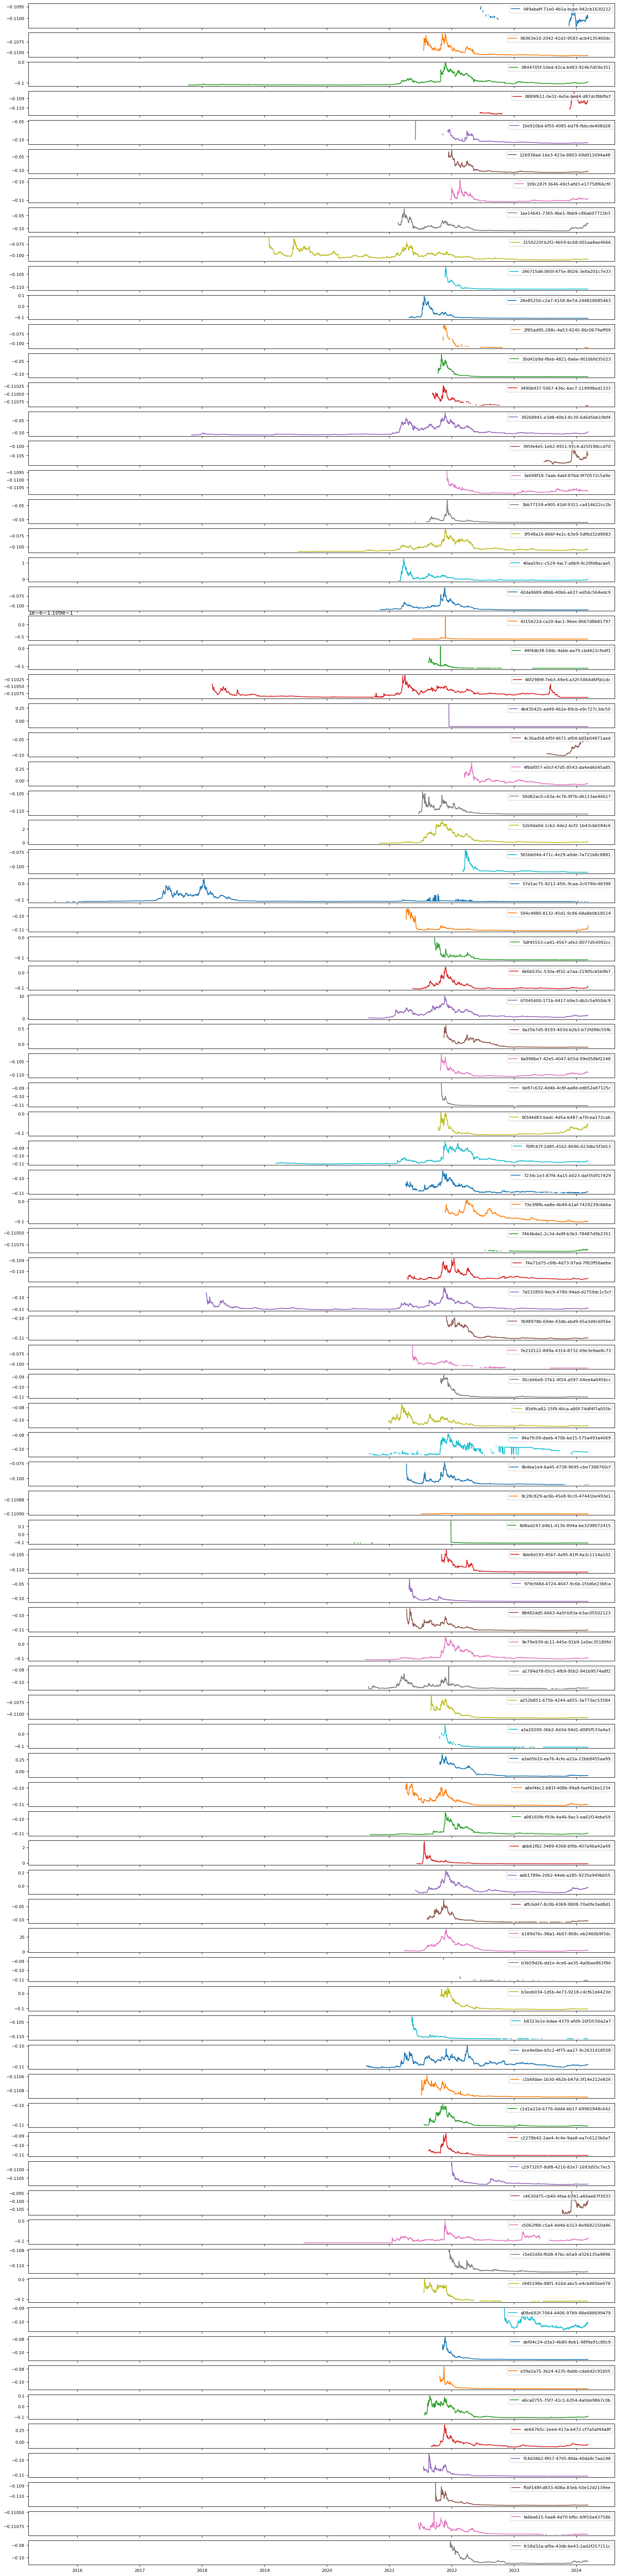

In [21]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
num_tokens = len(series_dict)
# Ensure there are enough colors
if len(colors) < num_tokens:
    colors = colors * (len(series_dict) // len(colors) + 1)
fig, axs = plt.subplots(num_tokens, 1, figsize=(20, num_tokens), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

In [22]:
def train_forecaster(series_dict: dict, exog_dict: exog_long_to_dict) -> ForecasterAutoregMultiSeries:
    regressor = LGBMRegressor(random_state=123, max_depth=5)
    forecaster = ForecasterAutoregMultiSeries(
                    regressor          = regressor,
                    lags               = 10,
                    encoding           = "ordinal",
                    dropna_from_series = False
                )
    
    forecaster.fit(series=series_dict, exog=exog_dict,suppress_warnings=True)
    
    return forecaster

In [23]:
forecaster = train_forecaster(series_dict, exog_dict)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2893
[LightGBM] [Info] Number of data points in the train set: 85397, number of used features: 12
[LightGBM] [Info] Start training from score 0.000477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [24]:
def predict_X_days(days_to_predict: int, future_exog_dict: exog_long_to_dict) -> pd.DataFrame:
    return forecaster.predict(steps=days_to_predict, exog=future_exog_dict, suppress_warnings=True)

In [25]:
predictions = predict_X_days(7, future_exog_dict)

In [26]:
predictions.head()

049abaff-71e0-4b1a-bcee-942cb1630222  \
2024-03-10                             -0.109935   
2024-03-11                             -0.109935   
2024-03-12                             -0.109935   
2024-03-13                             -0.109935   
2024-03-14                             -0.109935   

            06963e10-2042-41d3-9583-acb4135460dc  \
2024-03-10                             -0.110529   
2024-03-11                             -0.110529   
2024-03-12                             -0.110529   
2024-03-13                             -0.110529   
2024-03-14                             -0.110529   

            0844705f-10ed-42ca-b483-914b7d59e351  \
2024-03-10                             -0.095643   
2024-03-11                             -0.095643   
2024-03-12                             -0.095559   
2024-03-13                             -0.095559   
2024-03-14                             -0.095358   

            0889f611-0e32-4e5e-be44-d87dcf8bf9cf  \
2024-03-10                             -0.109308   
2024-03-11                             -0.109042   
2024-03-12                             -0.109308   
2024-03-13                             -0.109042   
2024-03-14                             -0.109308   

            10e910bd-6f50-4085-bd78-fbbcde408d28  \
2024-03-10                             -0.107919   
2024-03-11                             -0.107919   
2024-03-12                             -0.107919   
2024-03-13                             -0.107919   
2024-03-14                             -0.107919   

            126938ad-16e3-423a-8803-69d011694a48  \
2024-03-10                             -0.103385   
2024-03-11                             -0.102077   
2024-03-12                             -0.103385   
2024-03-13                             -0.102077   
2024-03-14                             -0.103385   

            199c287f-3646-49cf-afd3-e17758f66cf0  \
2024-03-10                             -0.109308   
2024-03-11                             -0.109042   
2024-03-12                             -0.109308   
2024-03-13                             -0.109042   
2024-03-14                             -0.109308   

            1ae14641-7365-4be1-9bb9-c86ab07715b3  \
2024-03-10                             -0.082597   
2024-03-11                             -0.082597   
2024-03-12                             -0.082597   
2024-03-13                             -0.082597   
2024-03-14                             -0.082597   

            2150225f-b2f2-4b59-bc68-001aa8ae4666  \
2024-03-10                             -0.108477   
2024-03-11                             -0.108051   
2024-03-12                             -0.108418   
2024-03-13                             -0.107919   
2024-03-14                             -0.108403   

            246715d6-065f-475e-8026-3e0a201c7e33  ...  \
2024-03-10                             -0.110529  ...   
2024-03-11                             -0.110529  ...   
2024-03-12                             -0.110529  ...   
2024-03-13                             -0.110529  ...   
2024-03-14                             -0.110529  ...   

            c945198e-88f1-416d-abc5-e4cb465be078  \
2024-03-10                             -0.110252   
2024-03-11                             -0.110161   
2024-03-12                             -0.110161   
2024-03-13                             -0.110161   
2024-03-14                             -0.110161   

            d08e692f-7064-4406-9789-98e688699479  \
2024-03-10                             -0.101644   
2024-03-11                             -0.101644   
2024-03-12                             -0.101644   
2024-03-13                             -0.101644   
2024-03-14                             -0.101644   

            def04c24-d3a3-4b80-8eb1-98f9a91c80c9  \
2024-03-10                             -0.110529   
2024-03-11                             -0.110529   
2024-03-12                             -0.110529   
2024-03-13        

In [27]:
def plot_predictions(series_dict, predictions_x_days, last_data_points=0, max_coins=None):
    tokens = list(series_dict.keys())
    
    if max_coins:
        tokens = tokens[:max_coins]
    
    for token_id in tokens:
        historical_data = series_dict[token_id]
        
        # Determine the number of steps ahead (based on the prediction length)
        steps_ahead = len(predictions_x_days)
        
        # Create a timeline for the predictions (future dates after the last historical data point)
        last_date = historical_data.index[-1]
        future_dates = pd.date_range(start=last_date, periods=steps_ahead + 1, freq='D')[1:]  # Skip the last date
        
        # Get the predicted values for the token
        if token_id in predictions_x_days.columns:
            predictions = pd.Series(predictions_x_days[token_id], index=future_dates, name='Predictions')
        else:
            continue
        
        # Concatenate historical data with predictions
        combined_data = pd.concat([historical_data, predictions])
        
        # Get only the last `last_data_points` from historical data
        if last_data_points > 0:
            combined_data = combined_data[-last_data_points:]
        
        # Plot the data
        plt.figure(figsize=(20, 5))
        plt.plot(combined_data.index, combined_data, label='Historical + Predictions')
        plt.axvline(x=last_date, color='red', linestyle='--', label='Start of Predictions')
        plt.title(f'Token: {token_id} - Historical Data and {steps_ahead}-Day Forecast')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        
        # Display plot
        plt.show()

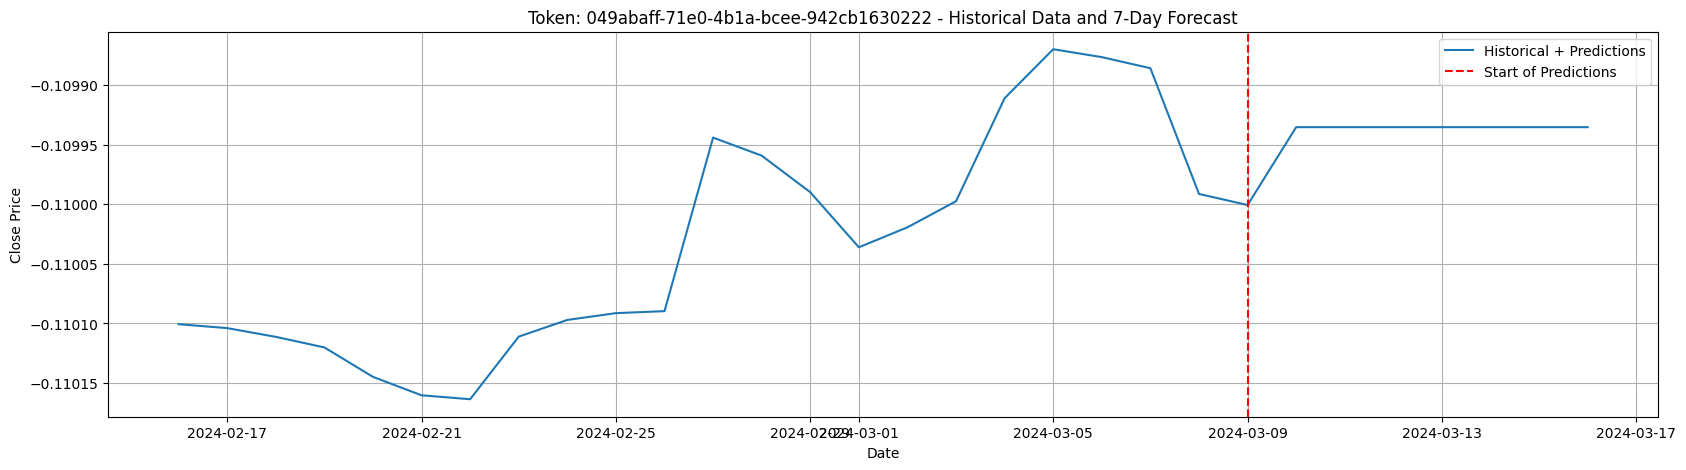

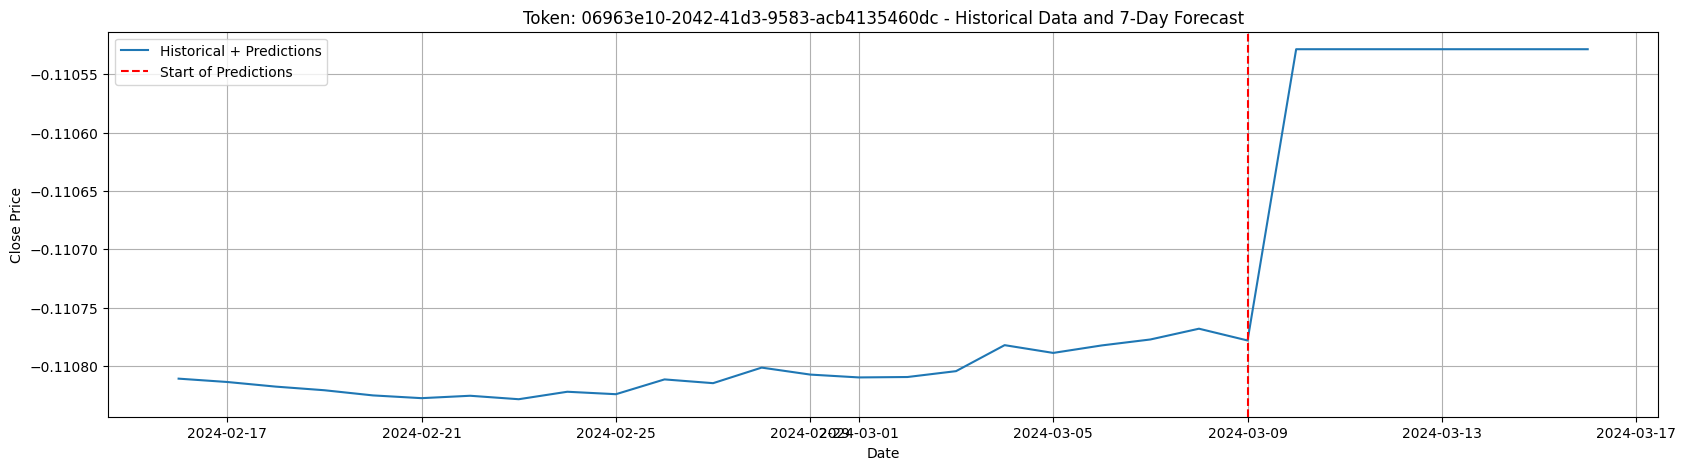

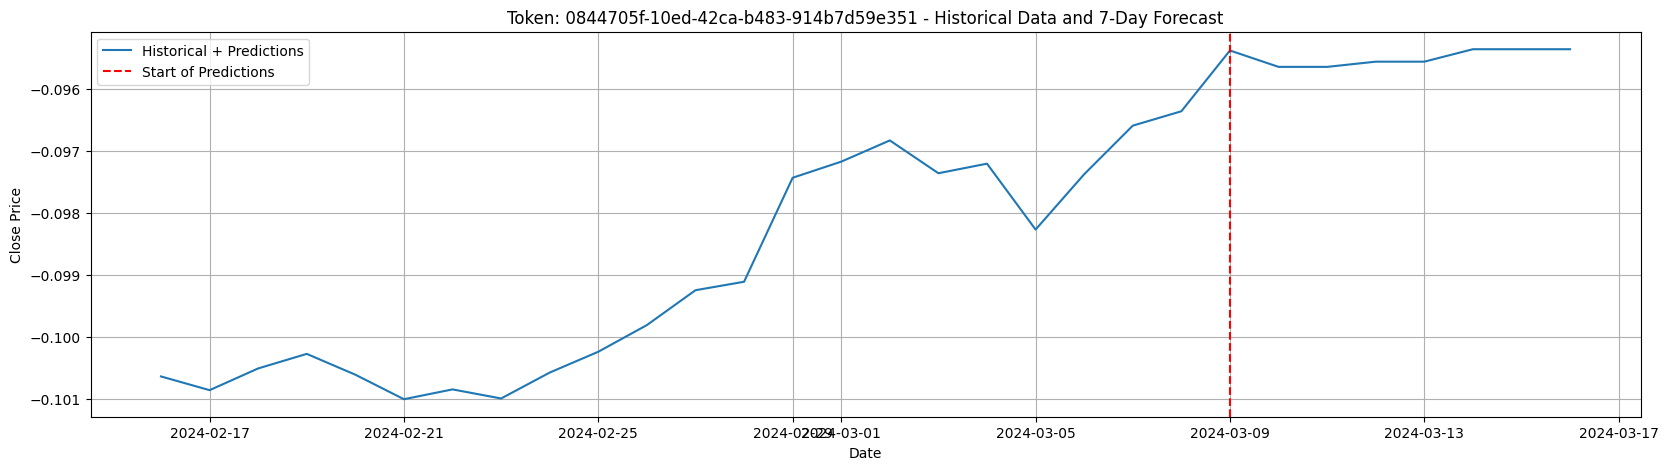

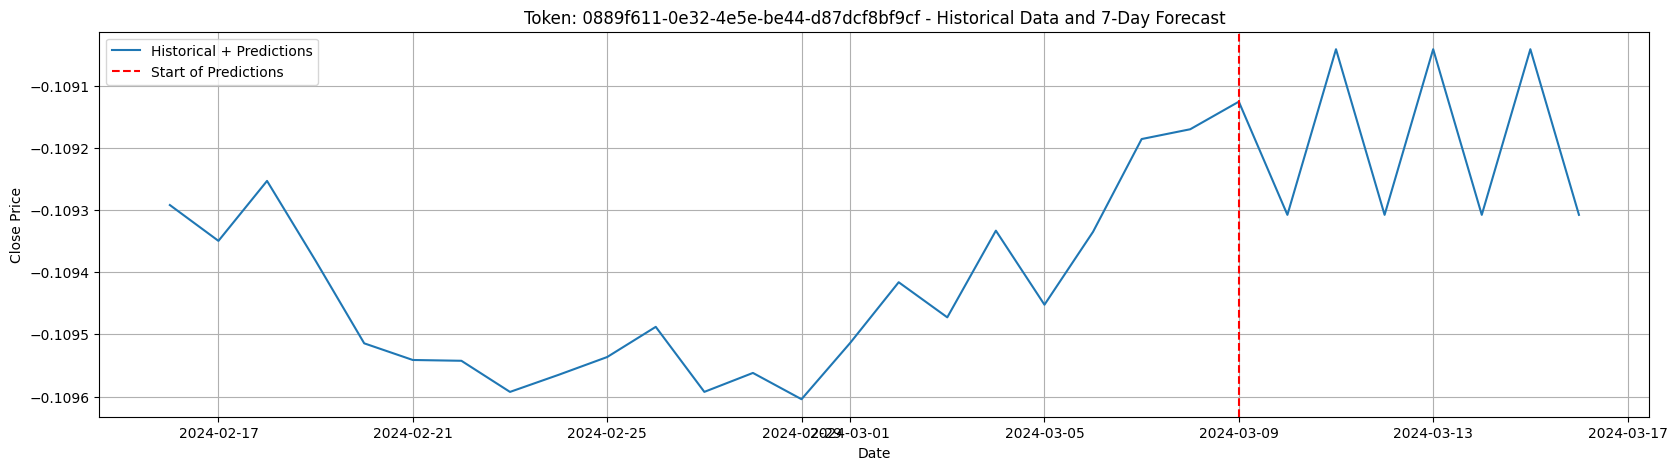

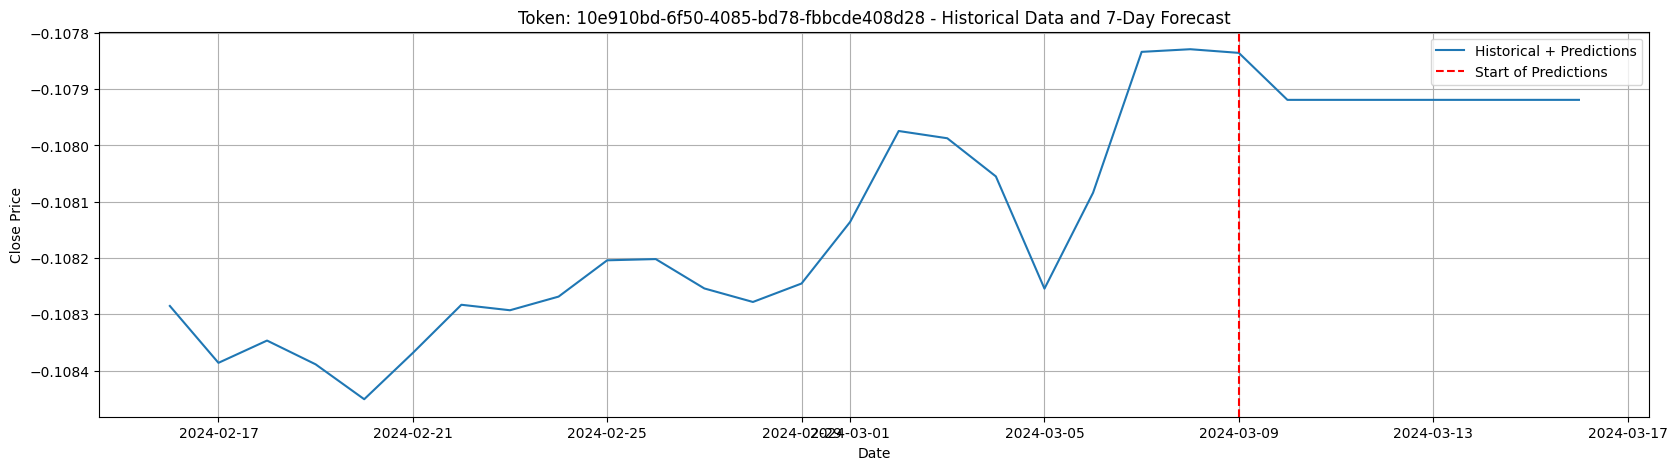

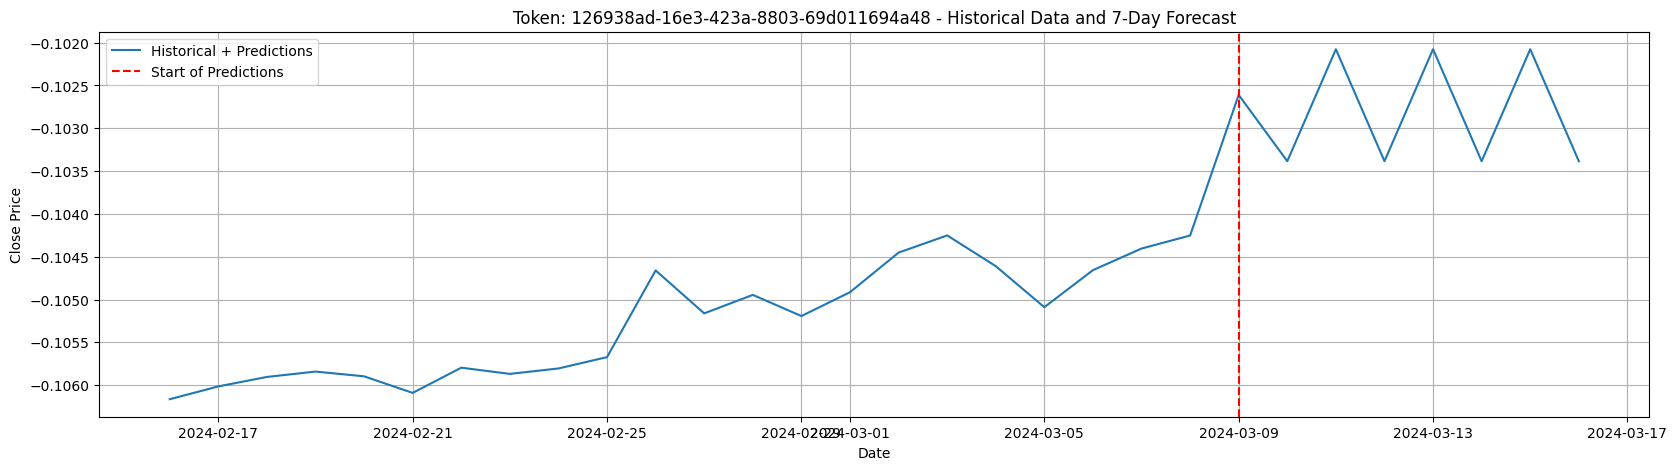

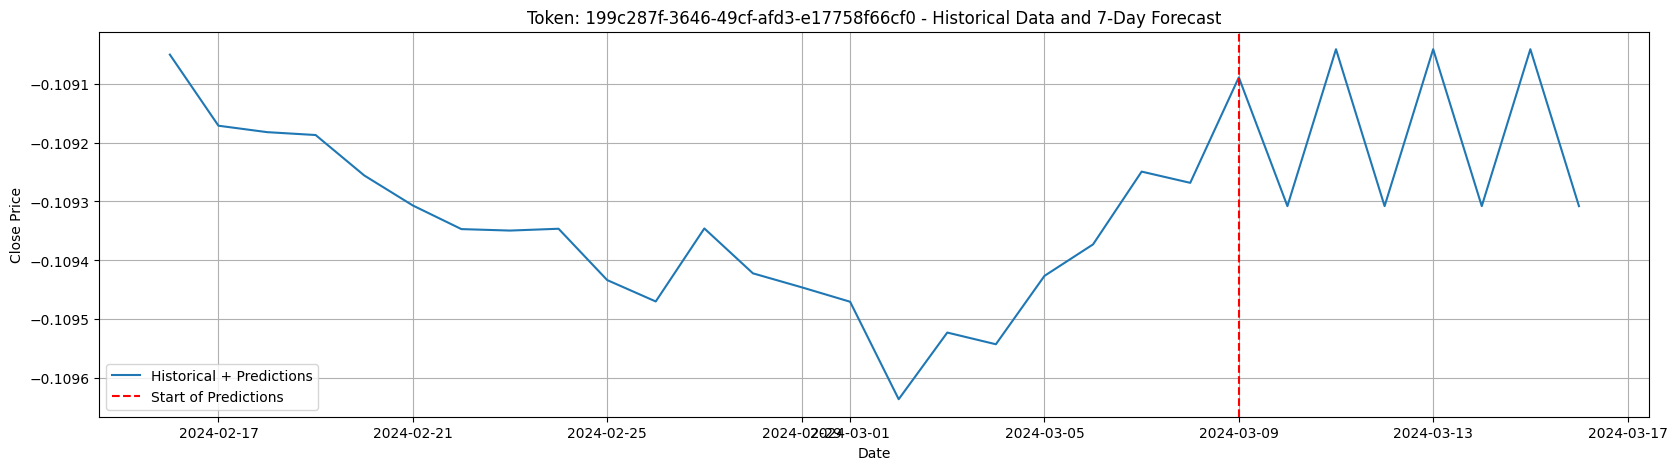

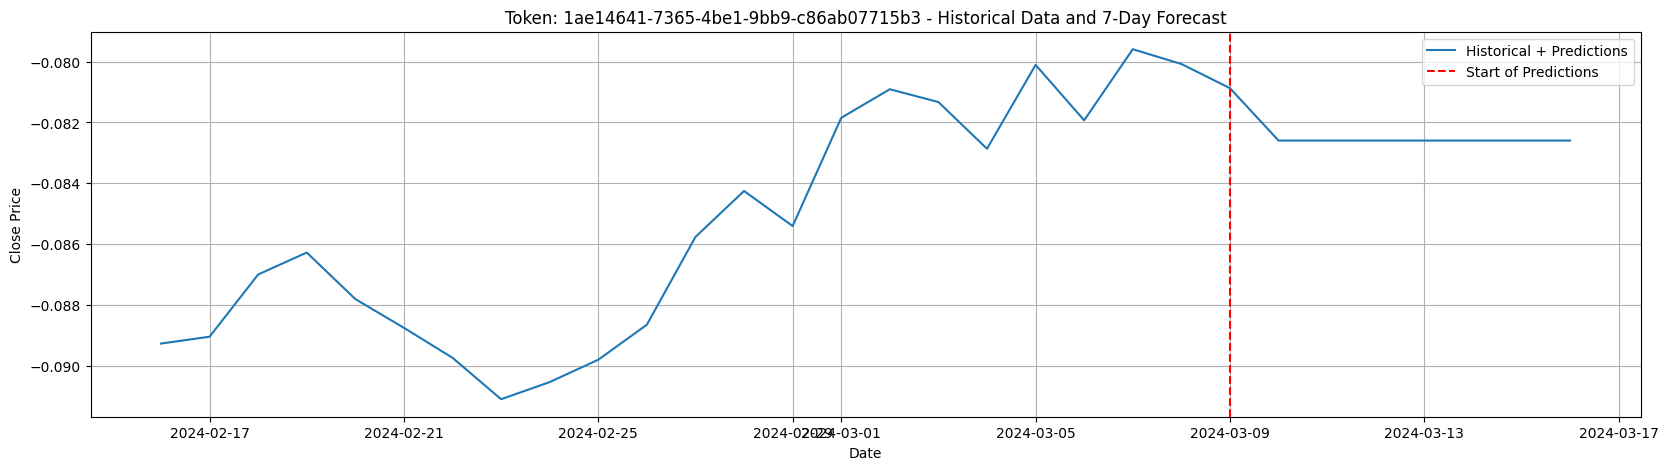

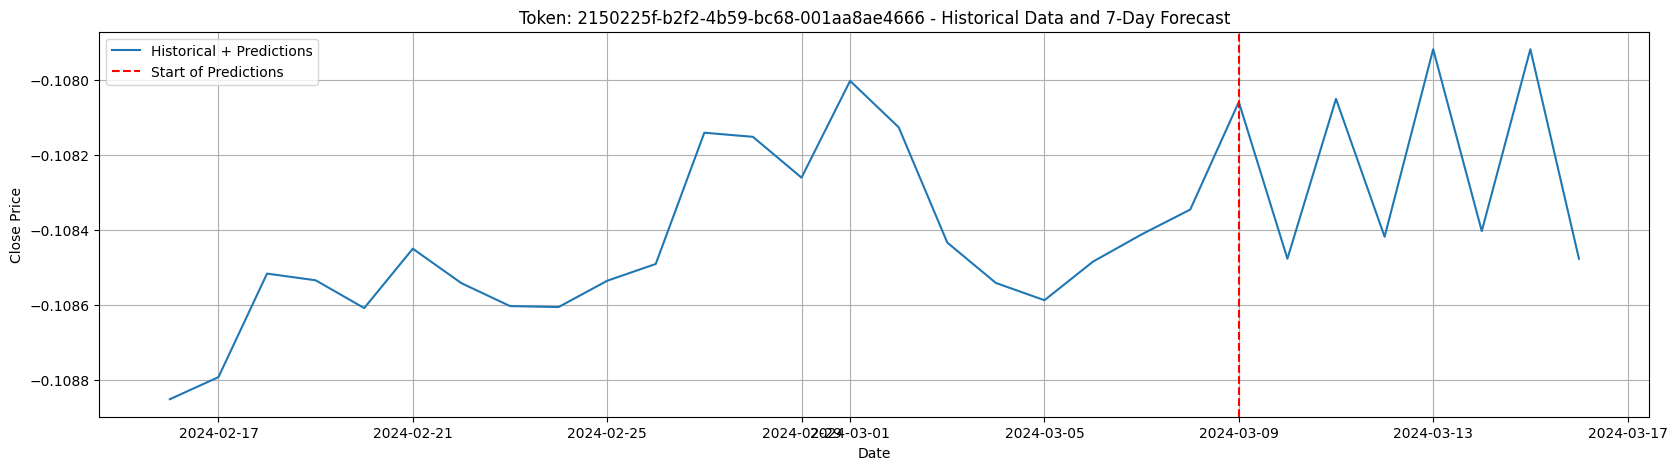

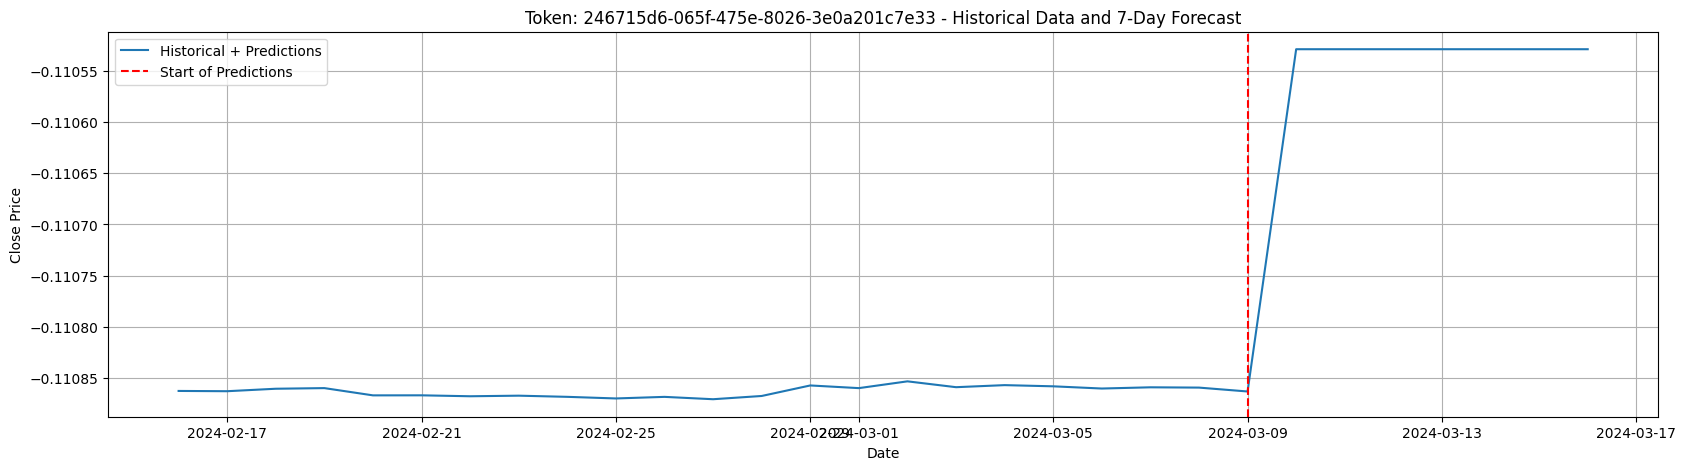

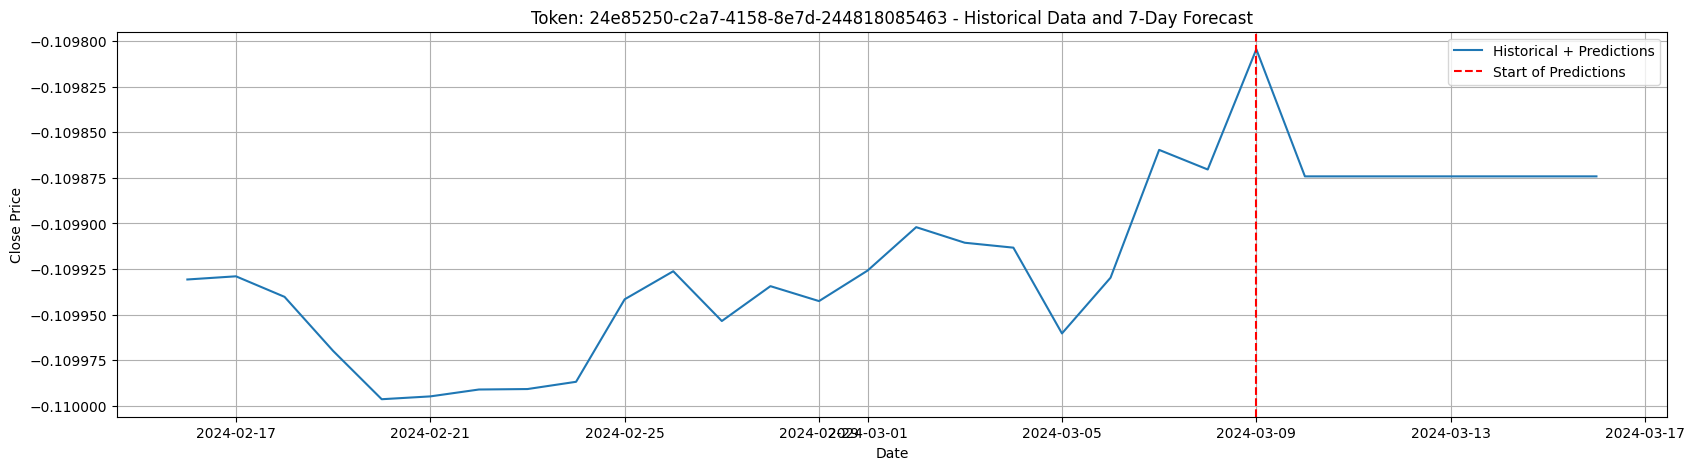

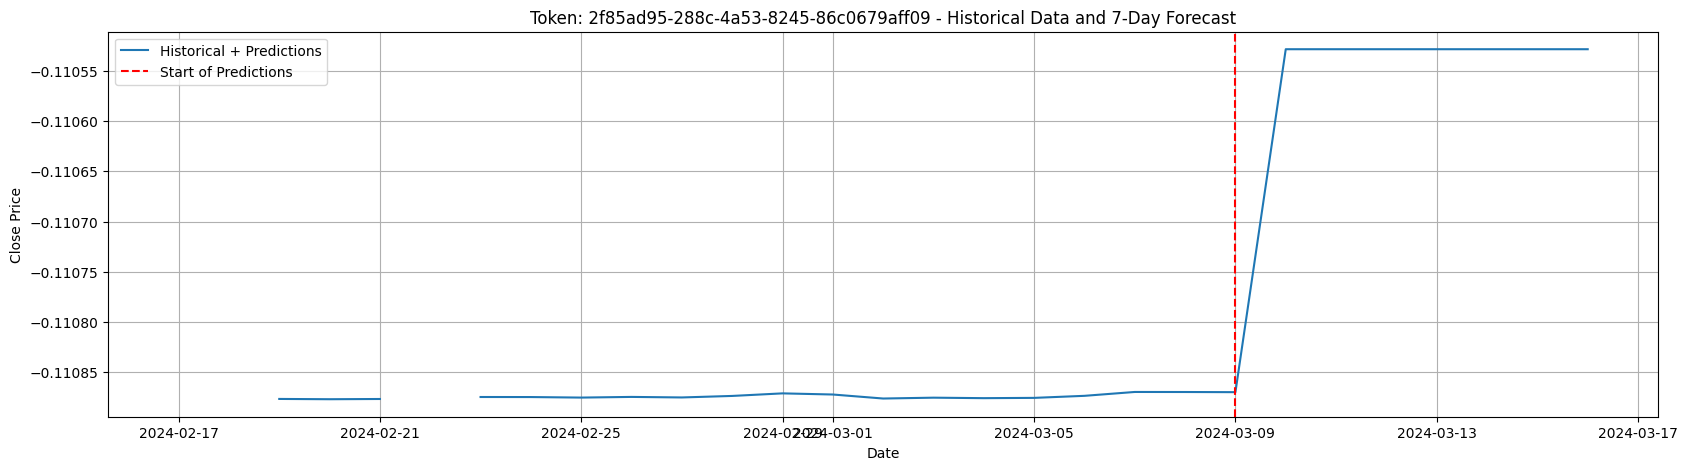

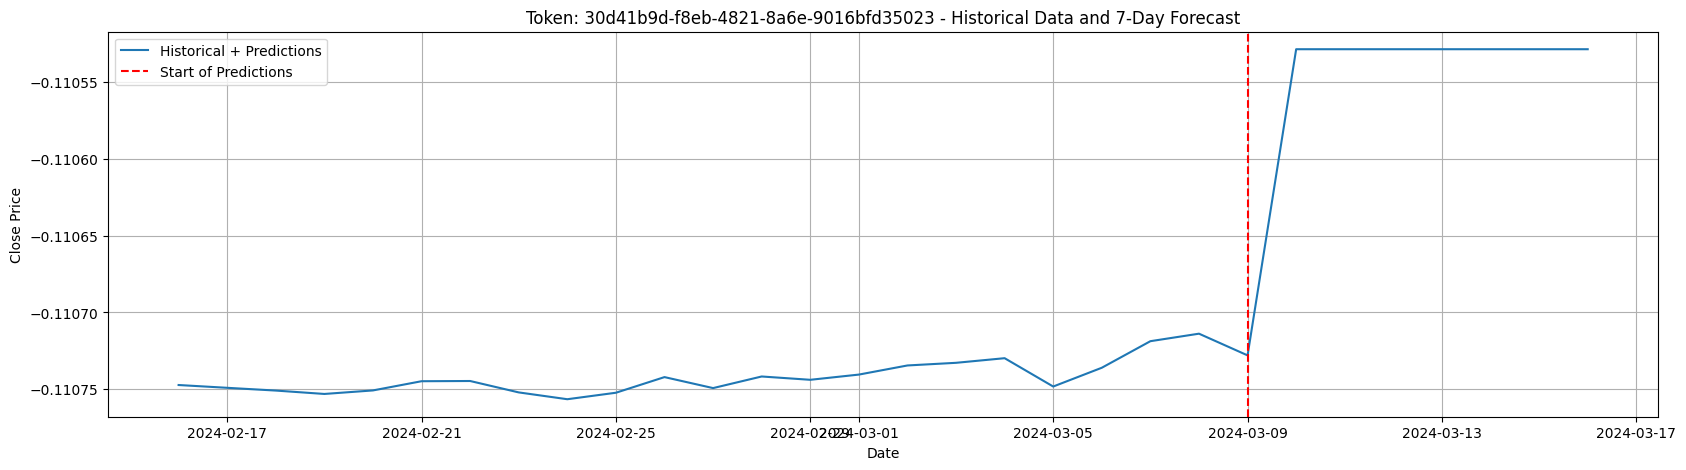

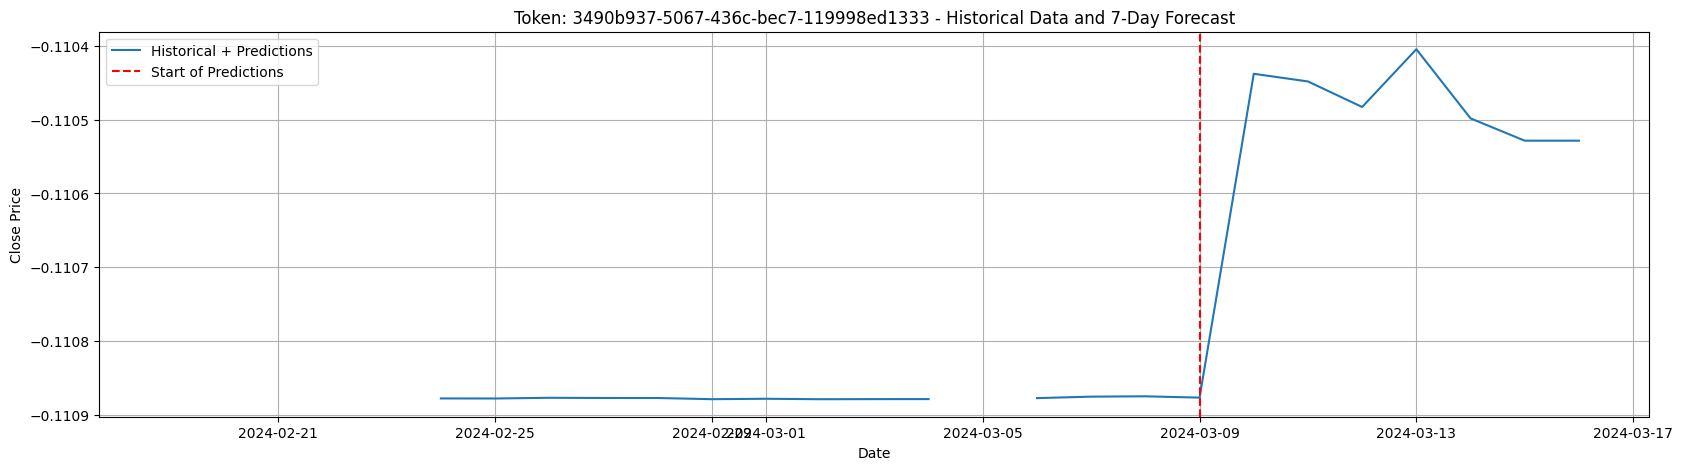

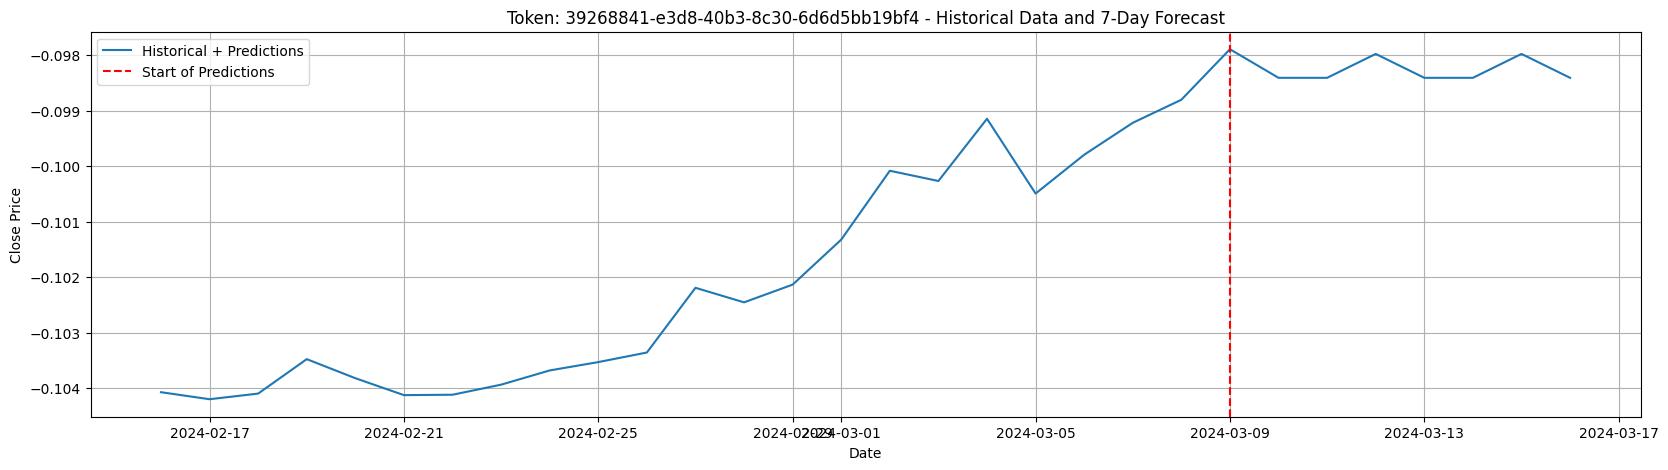

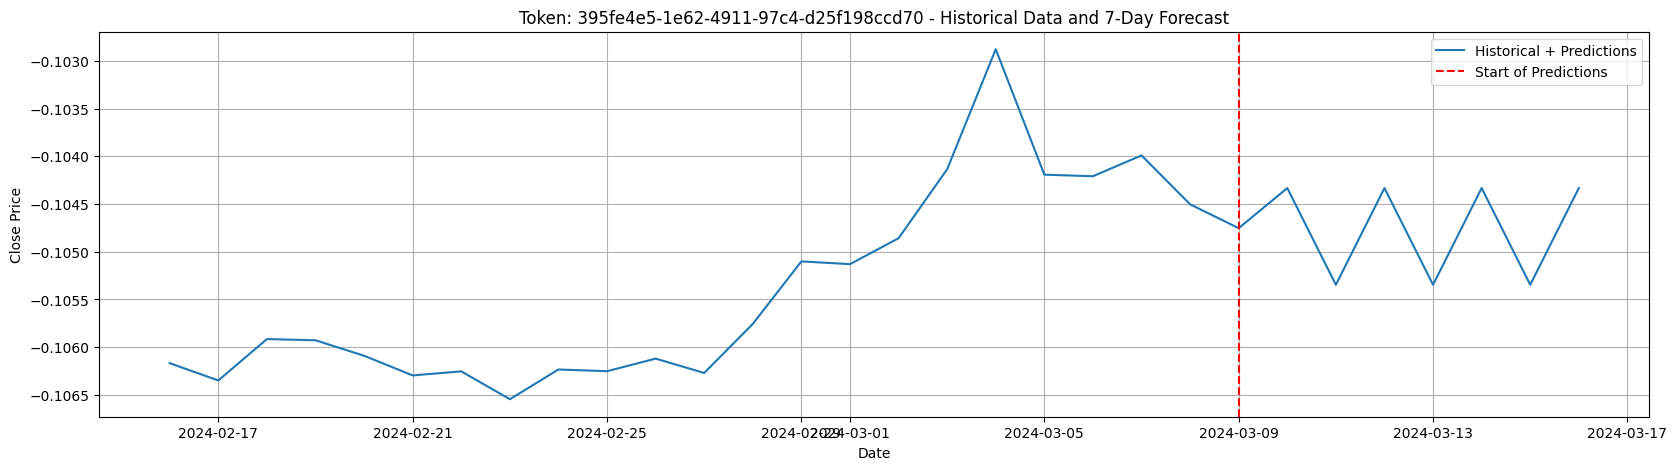

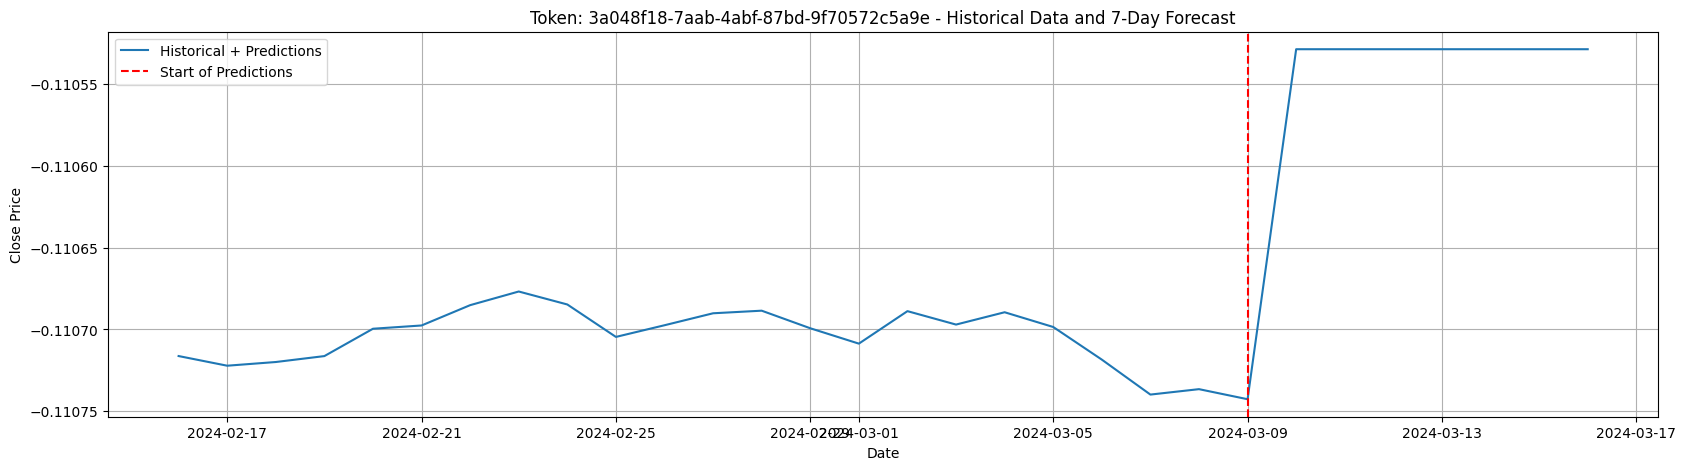

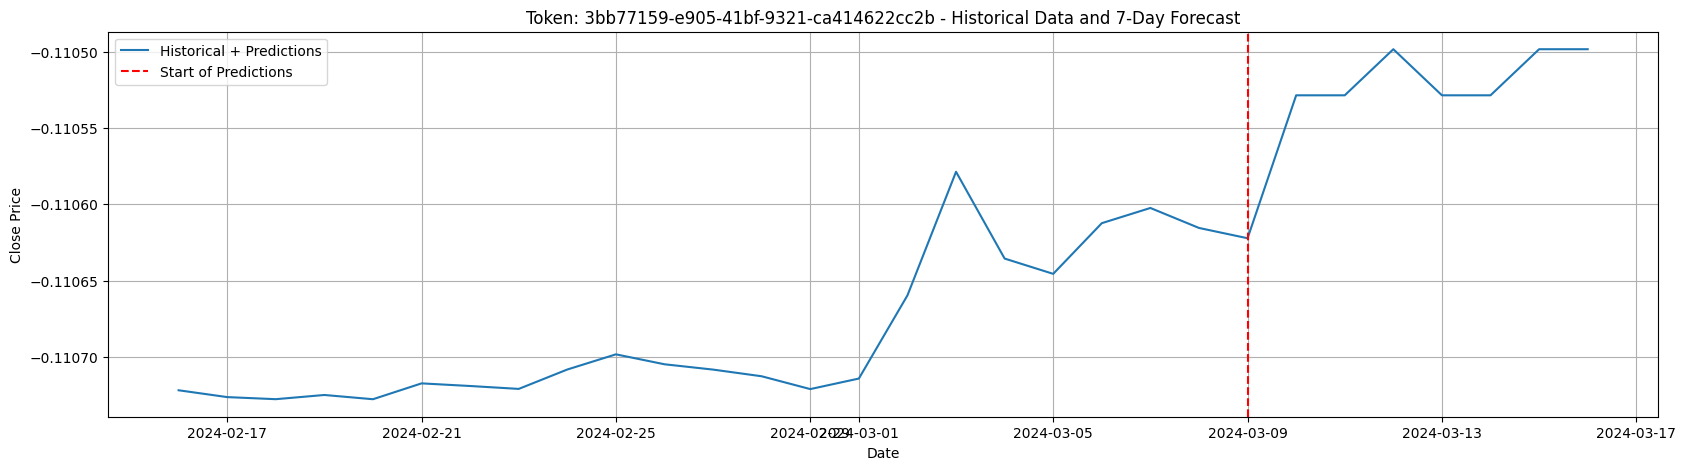

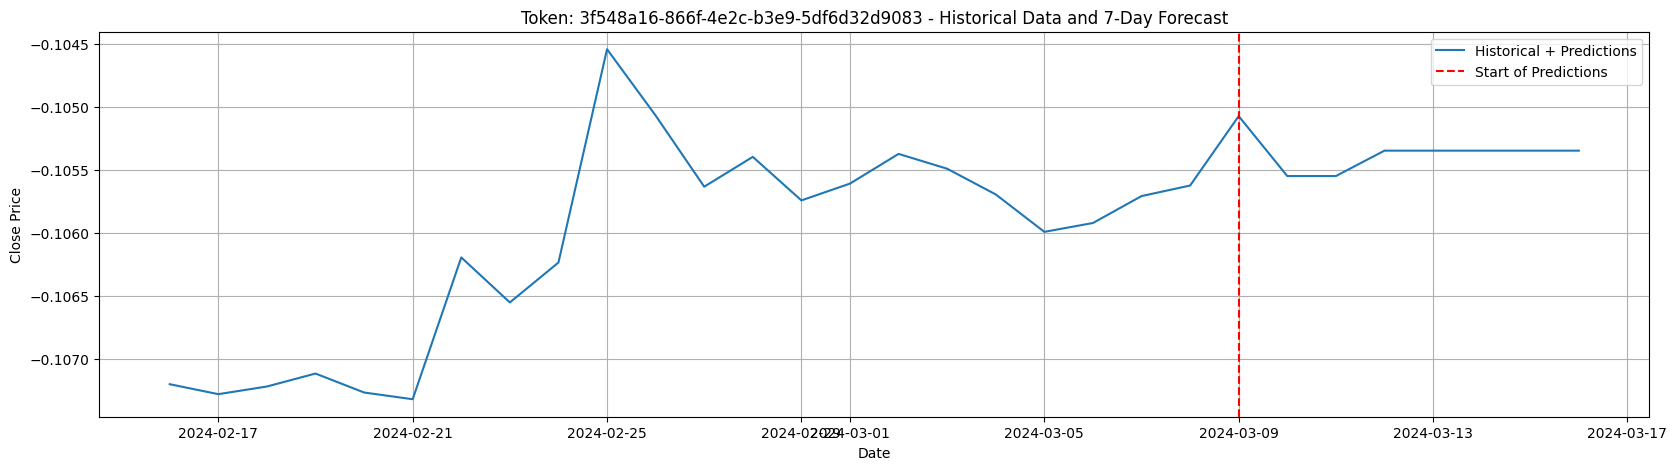

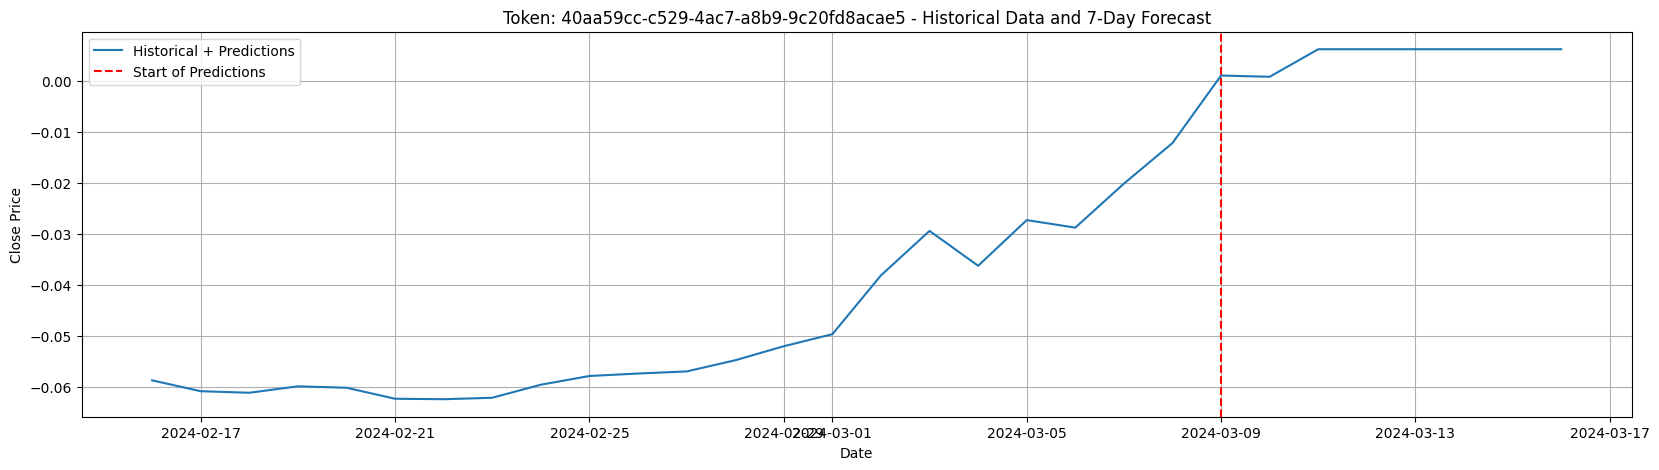

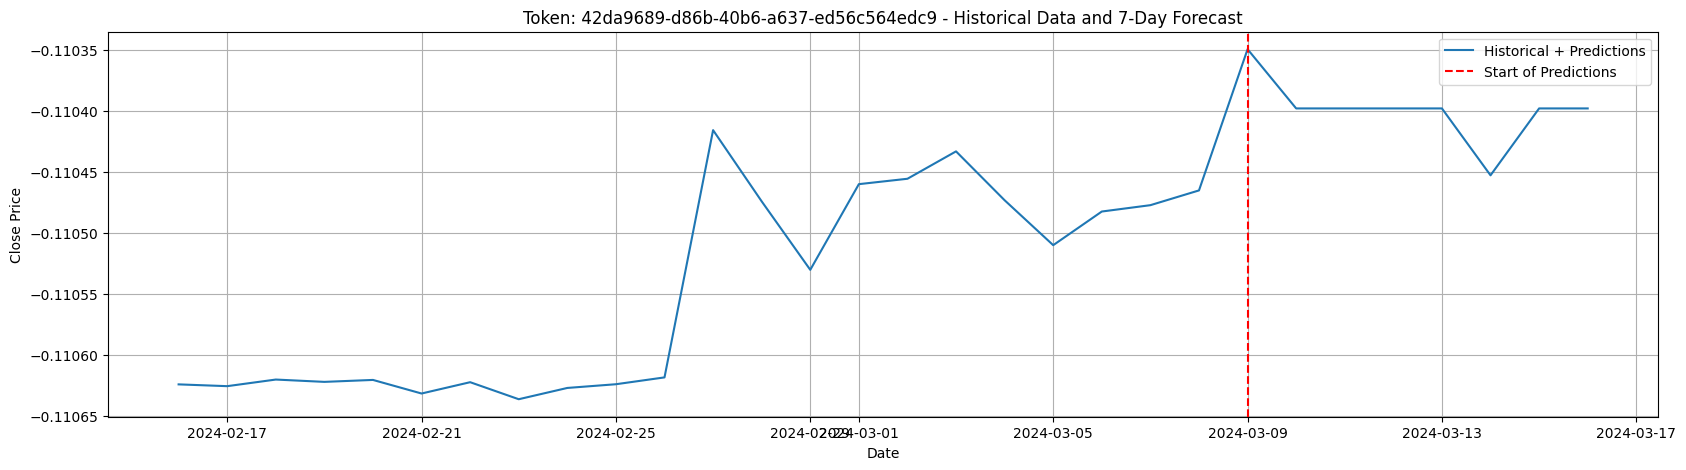

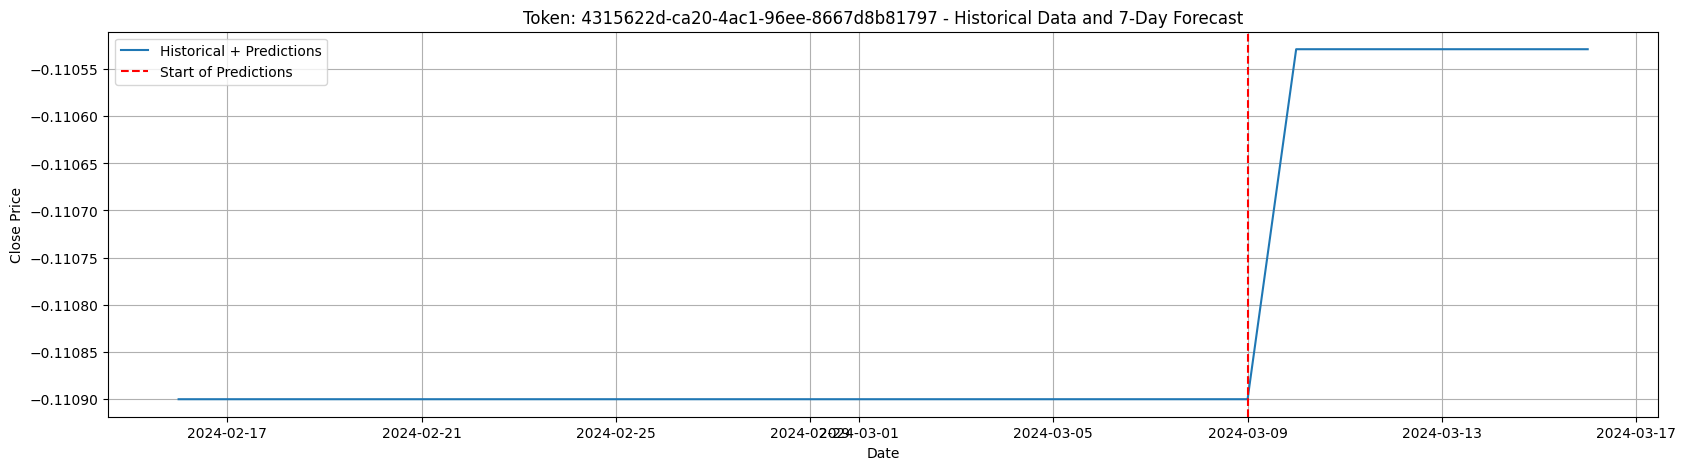

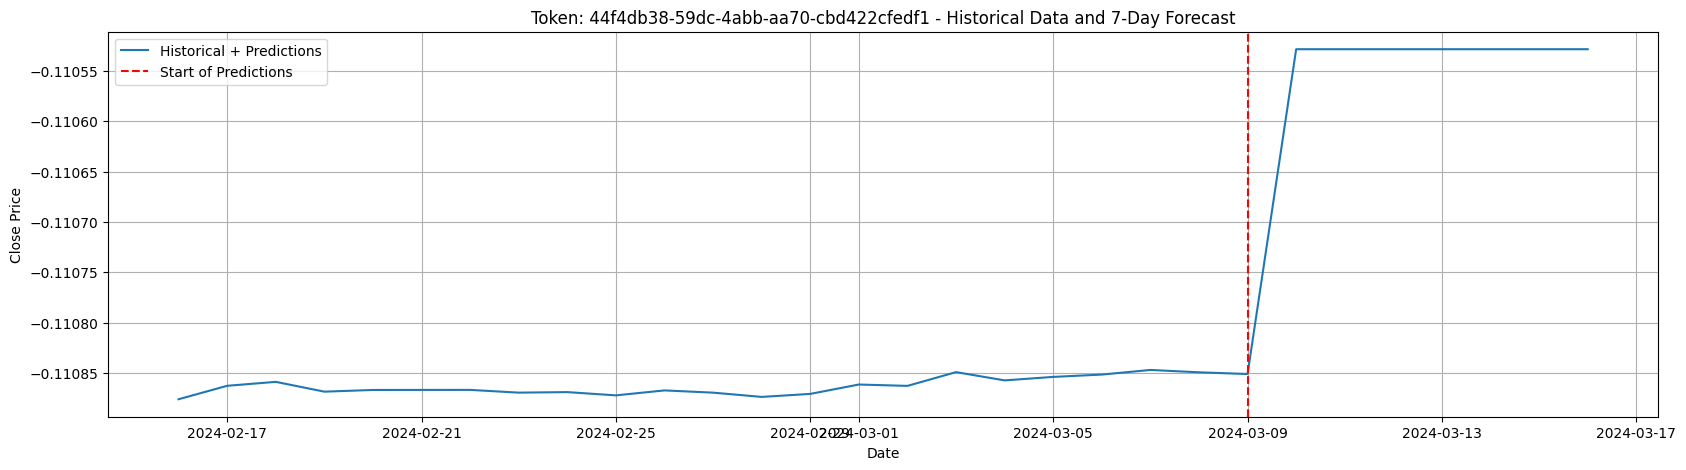

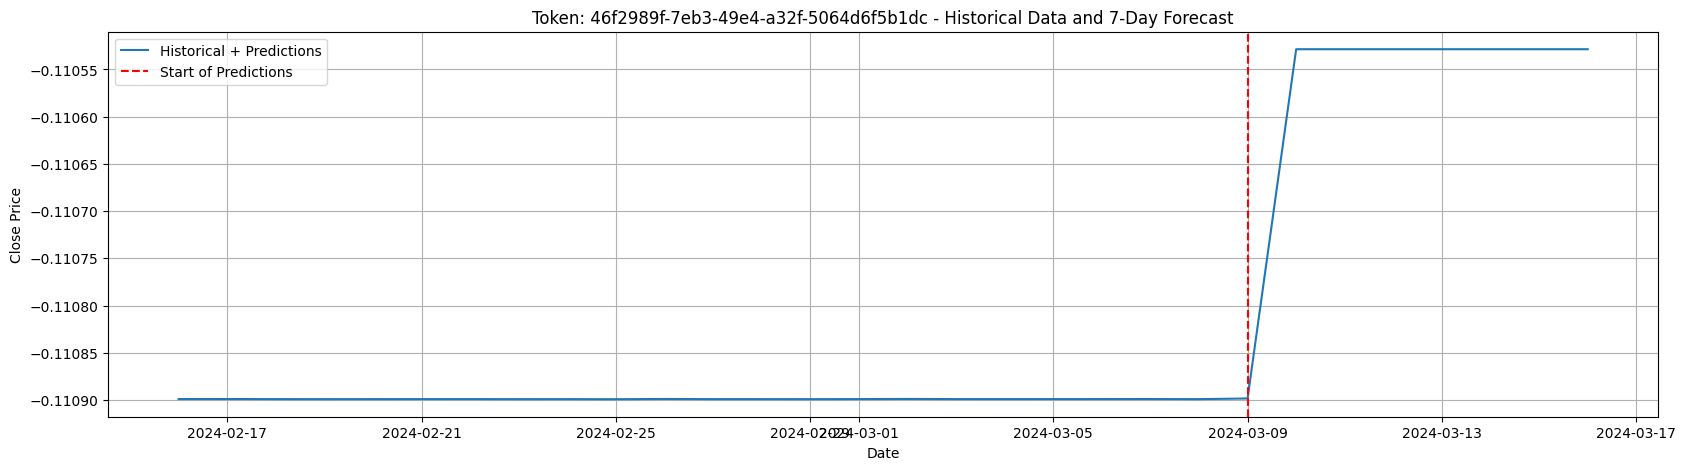

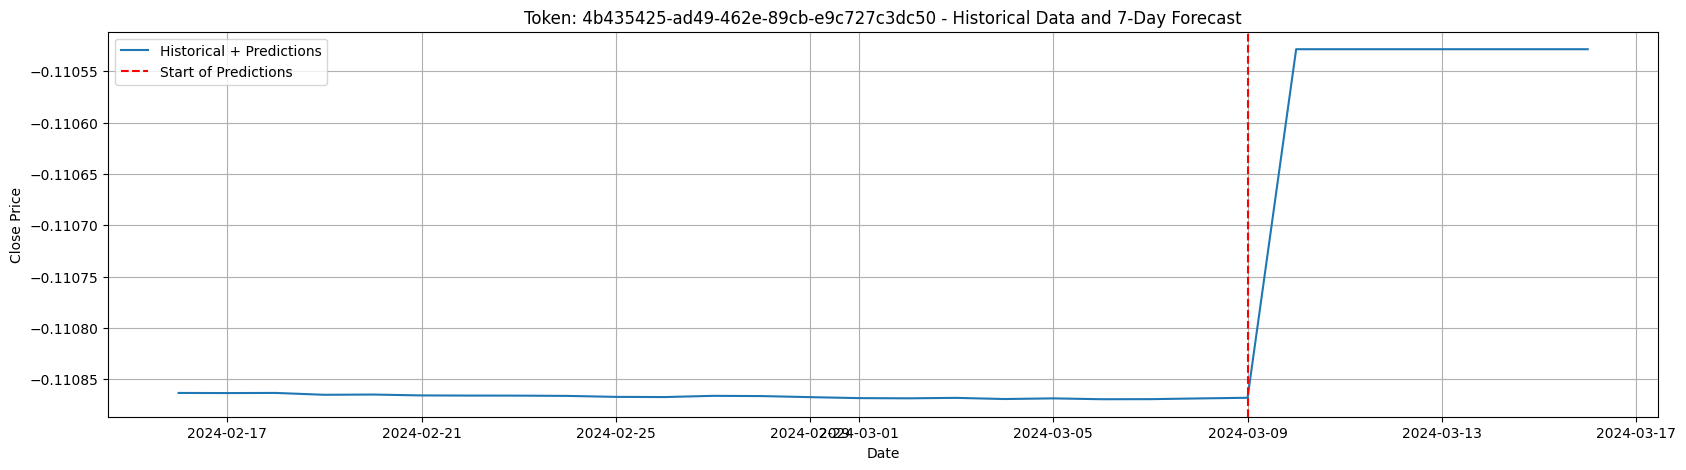

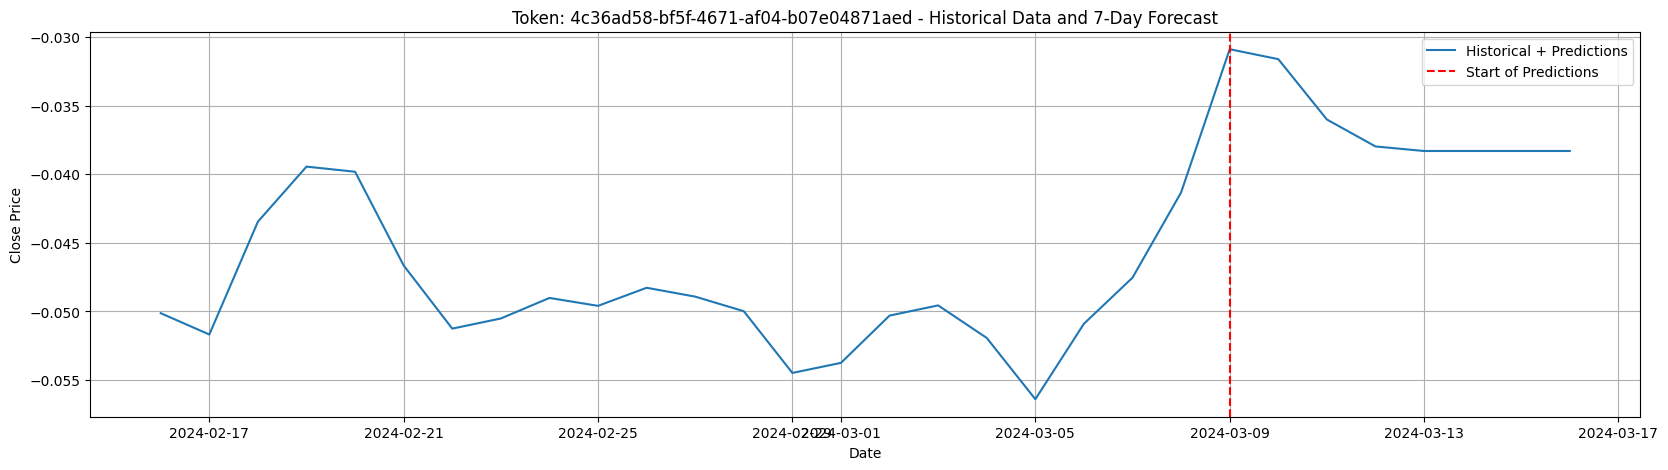

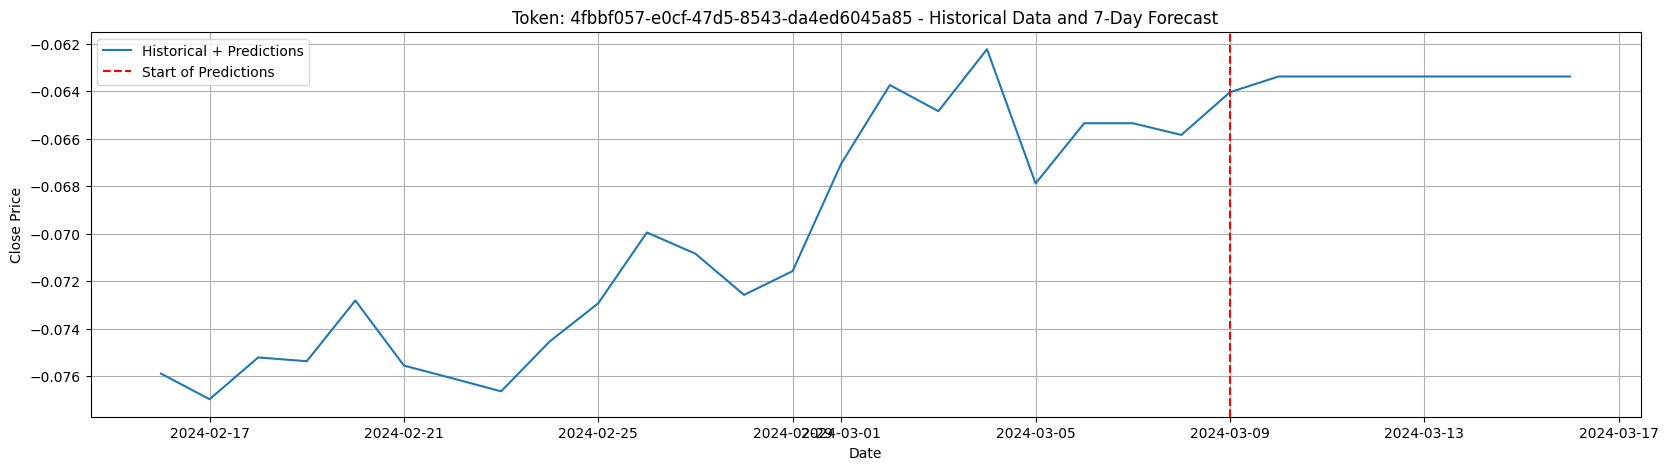

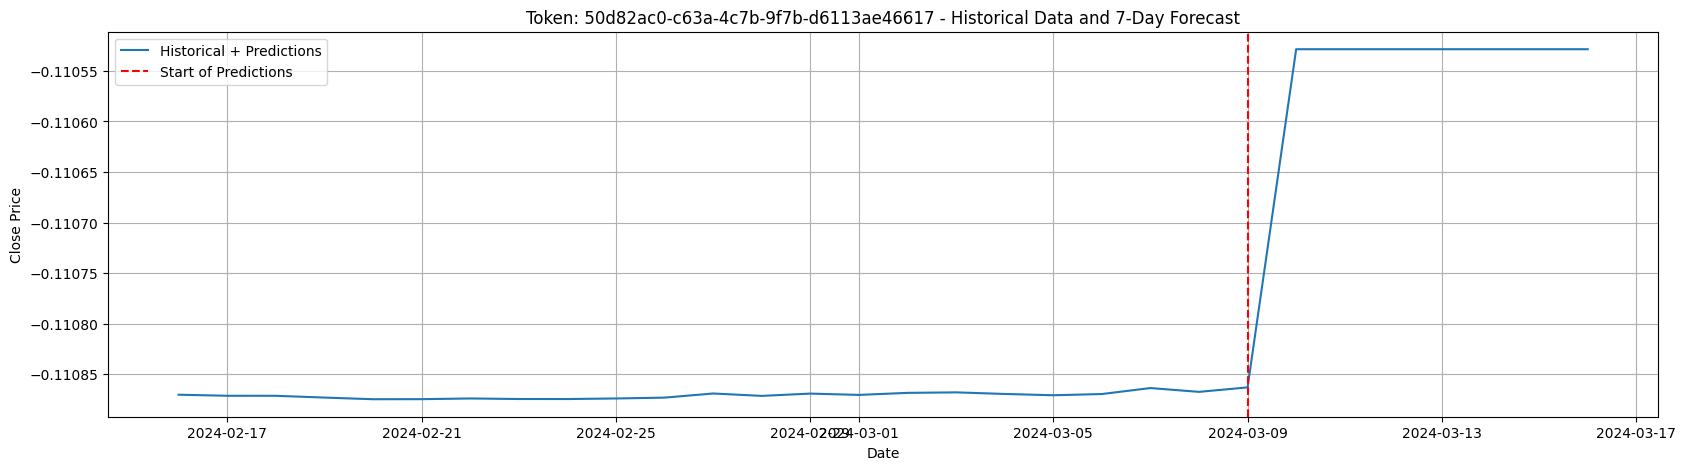

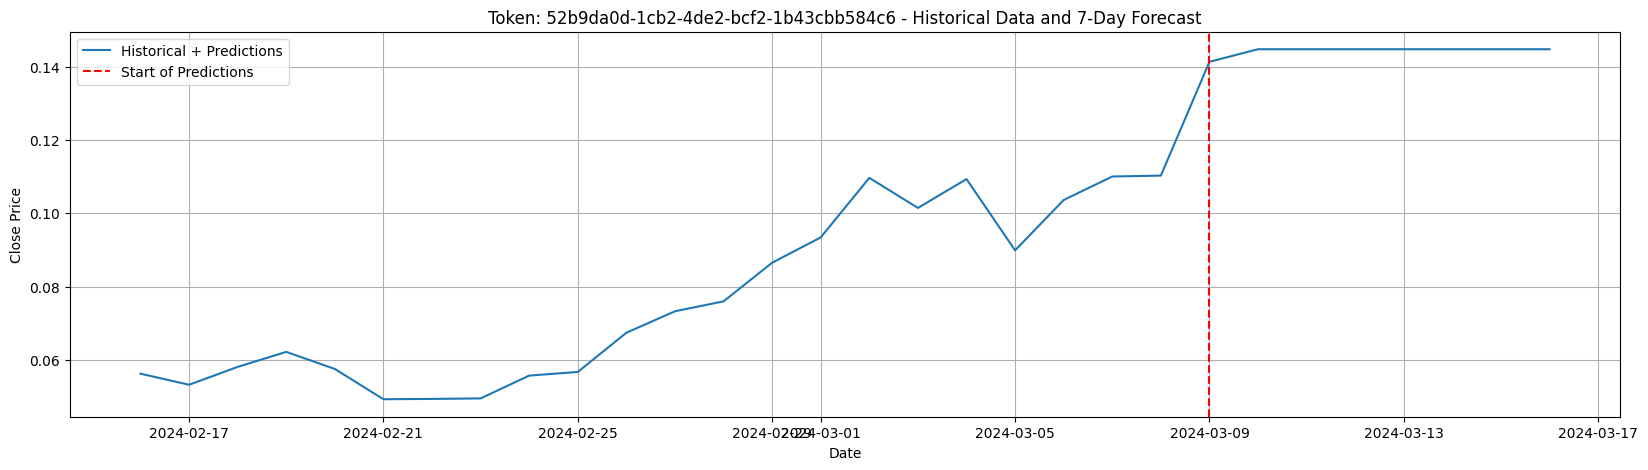

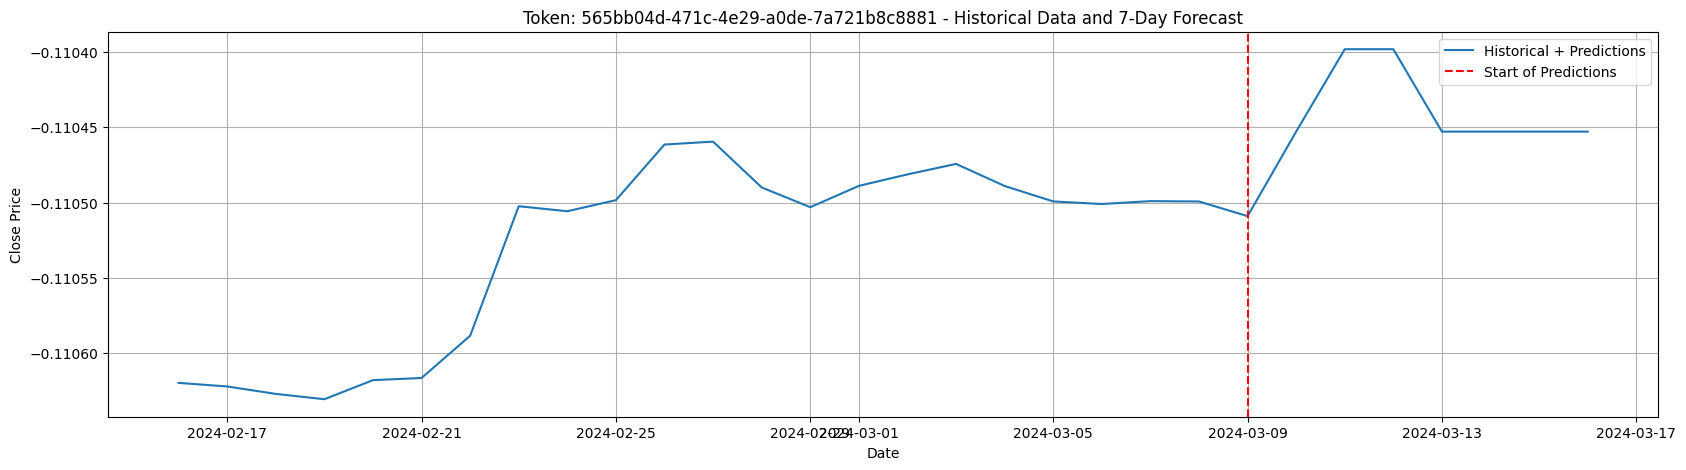

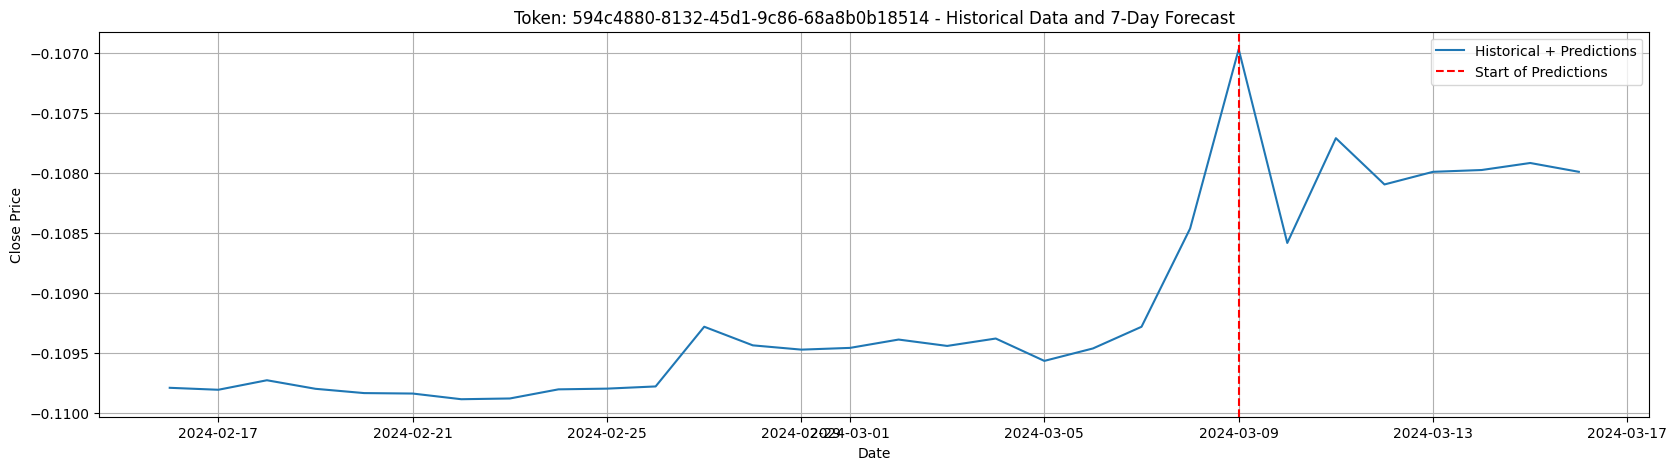

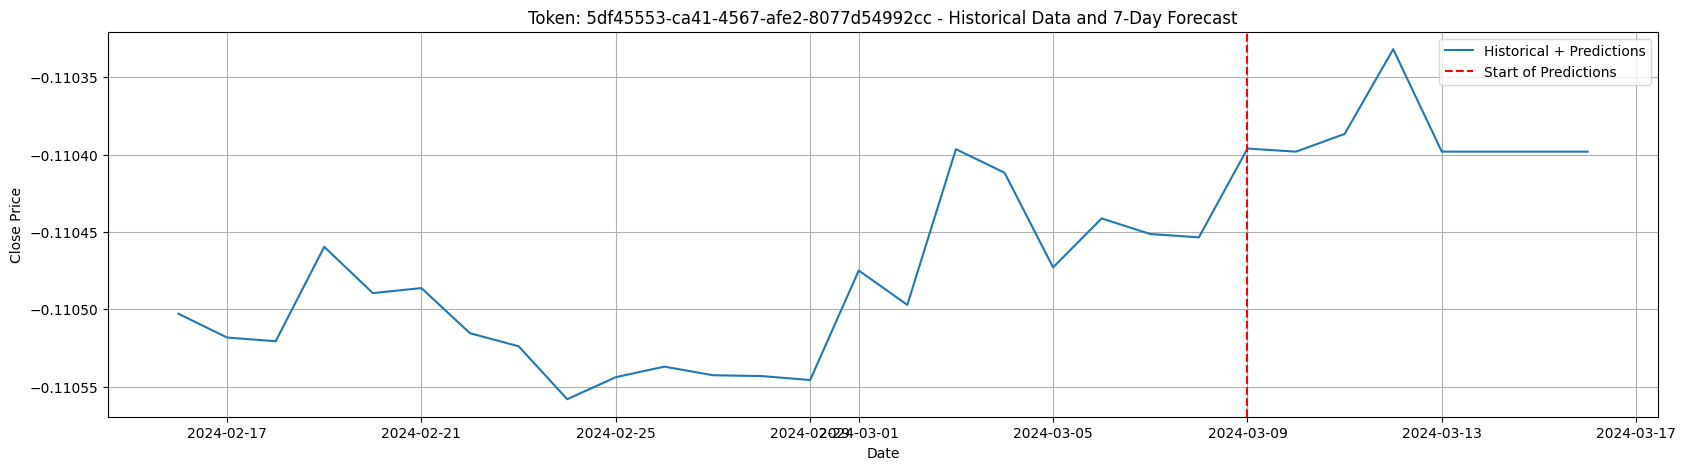

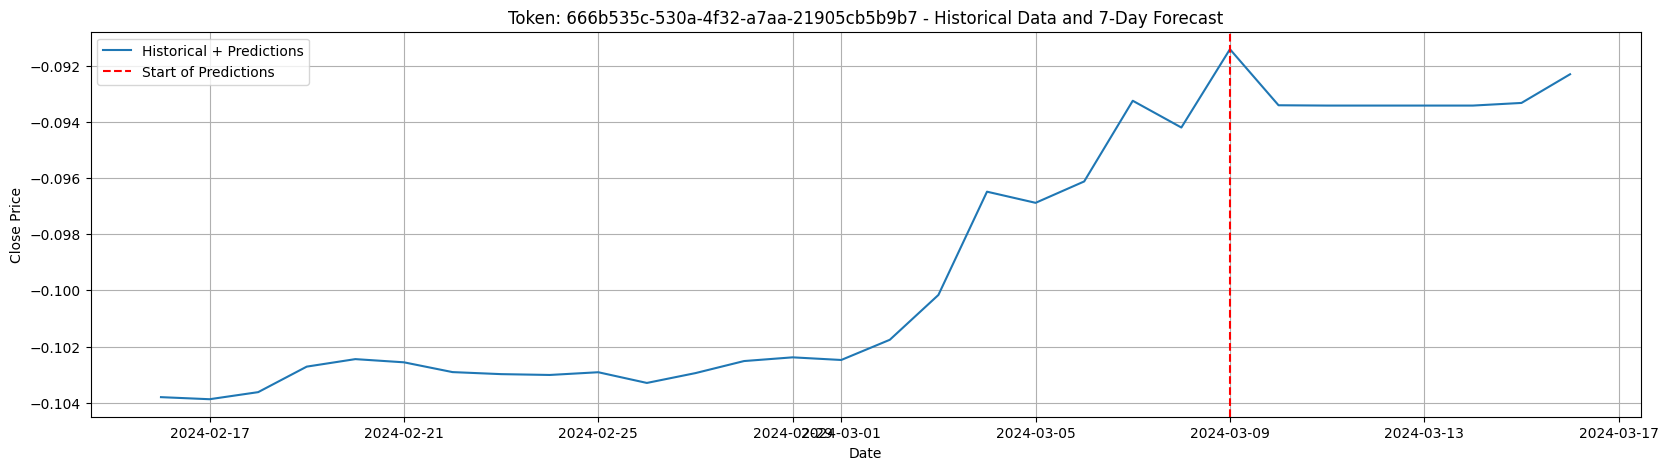

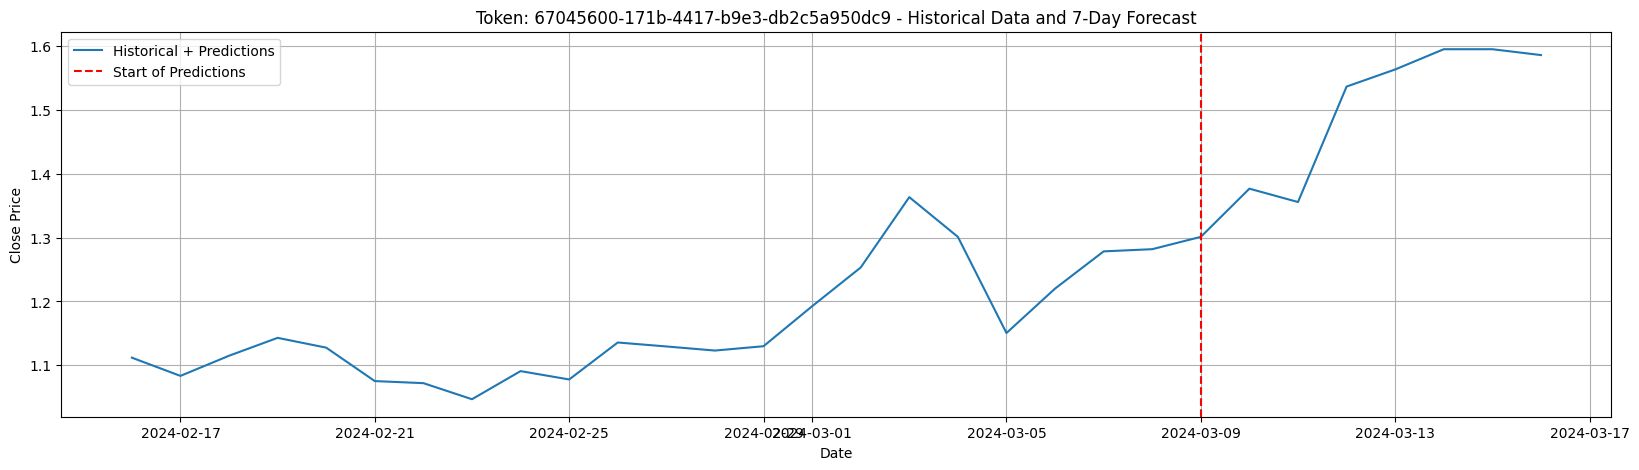

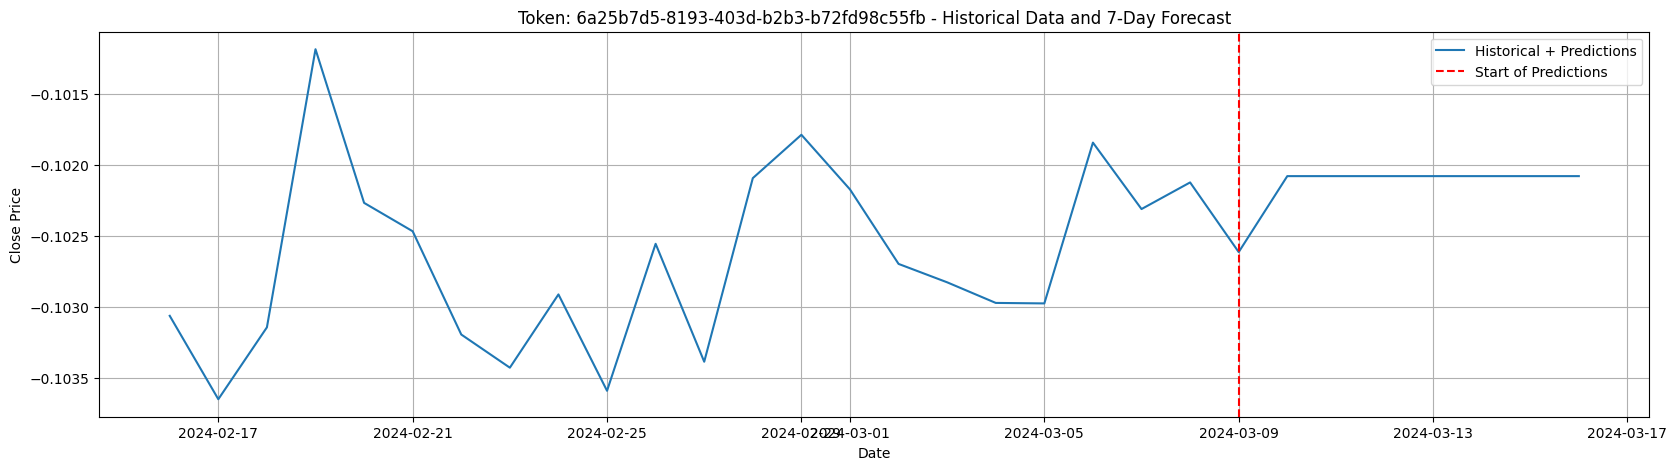

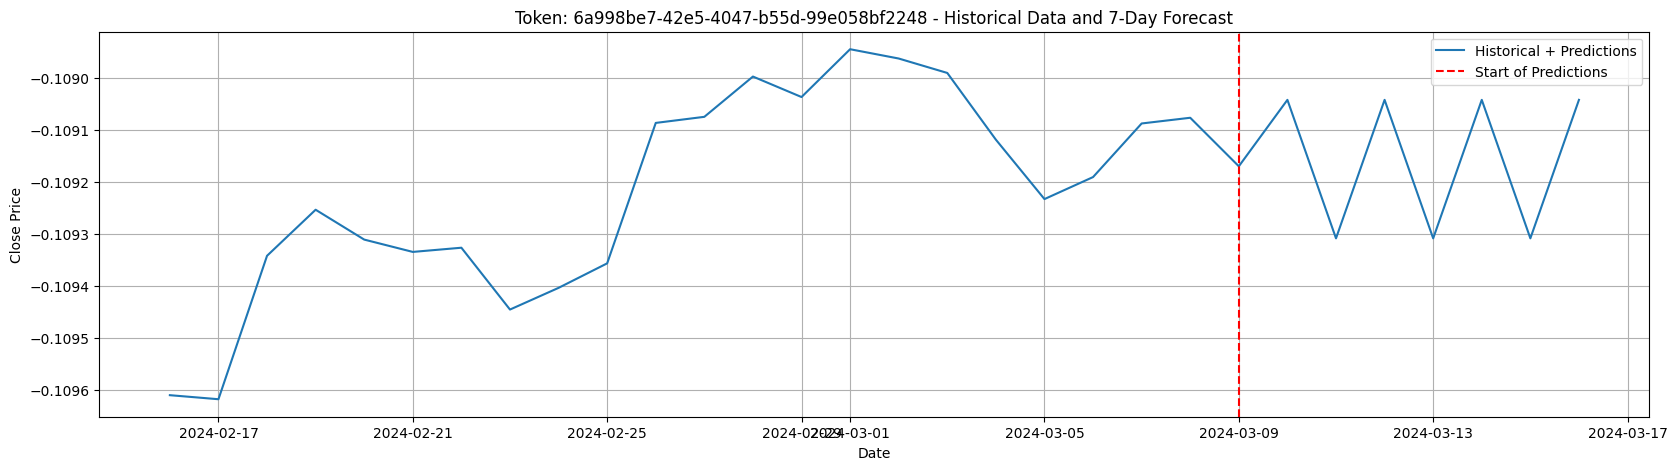

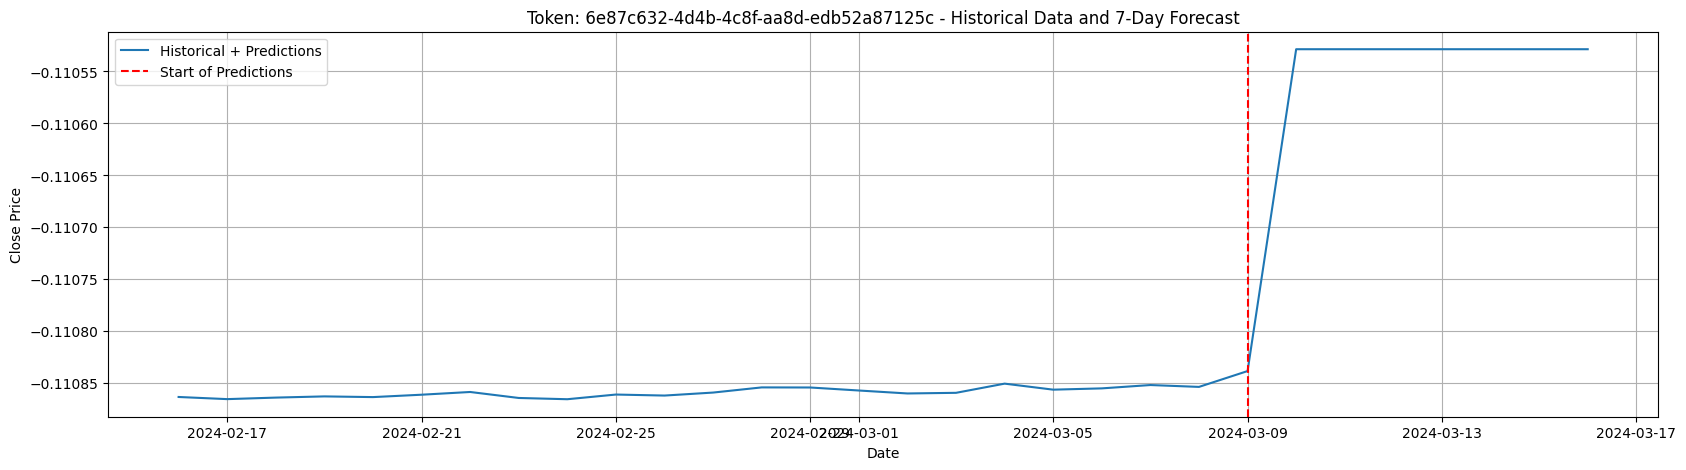

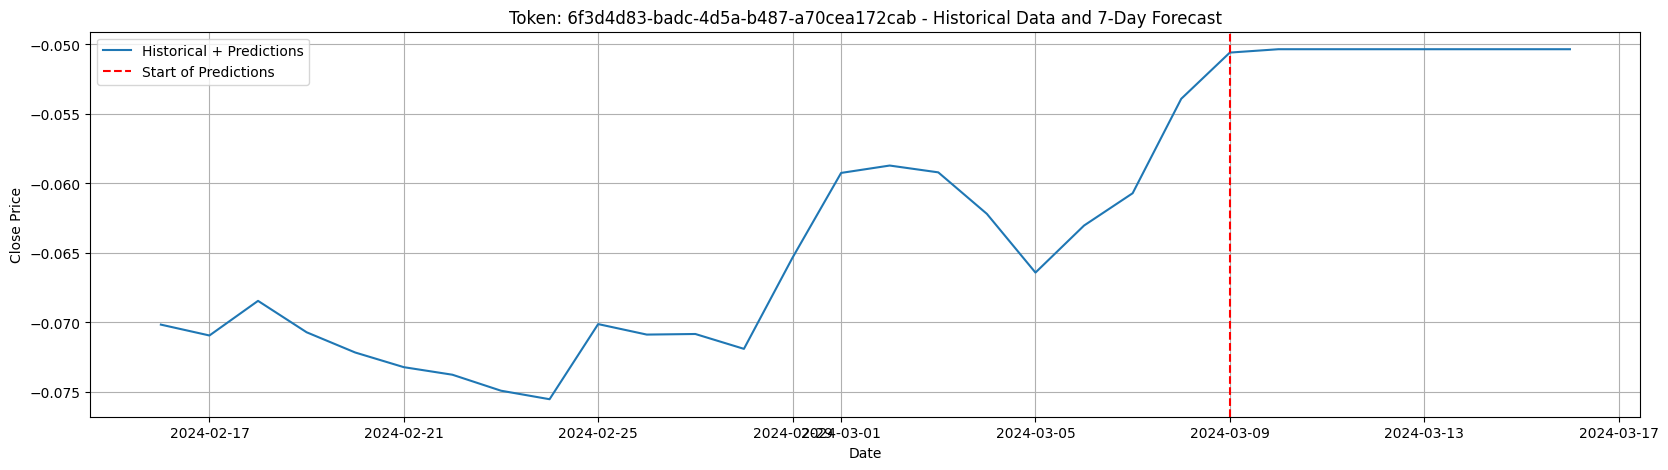

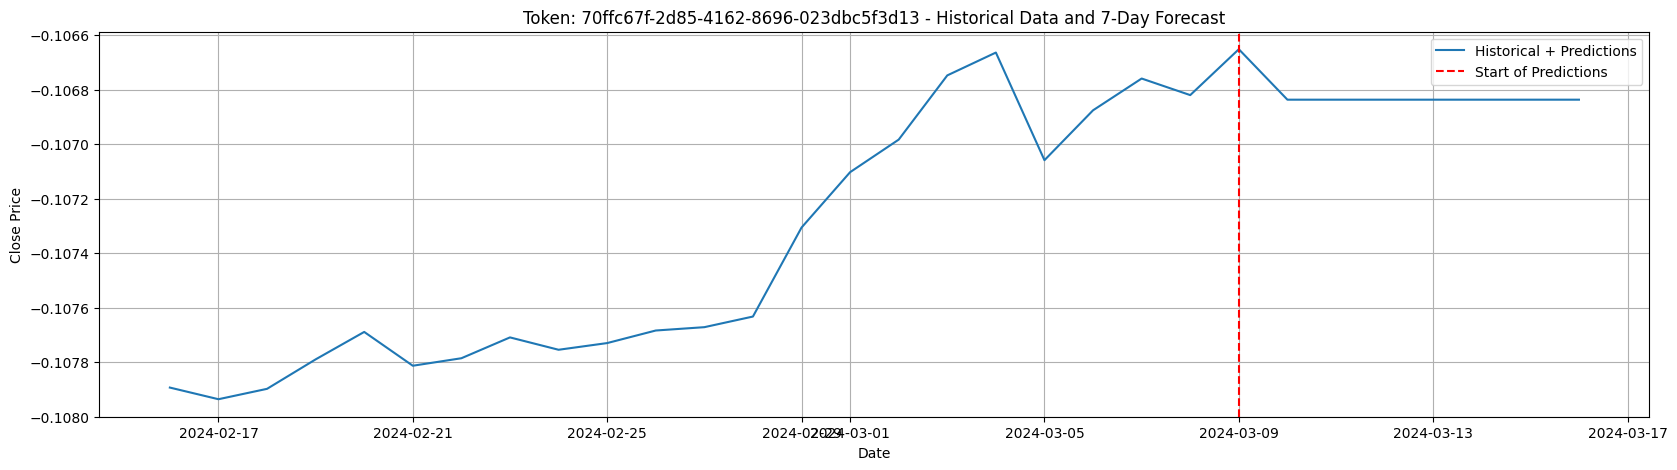

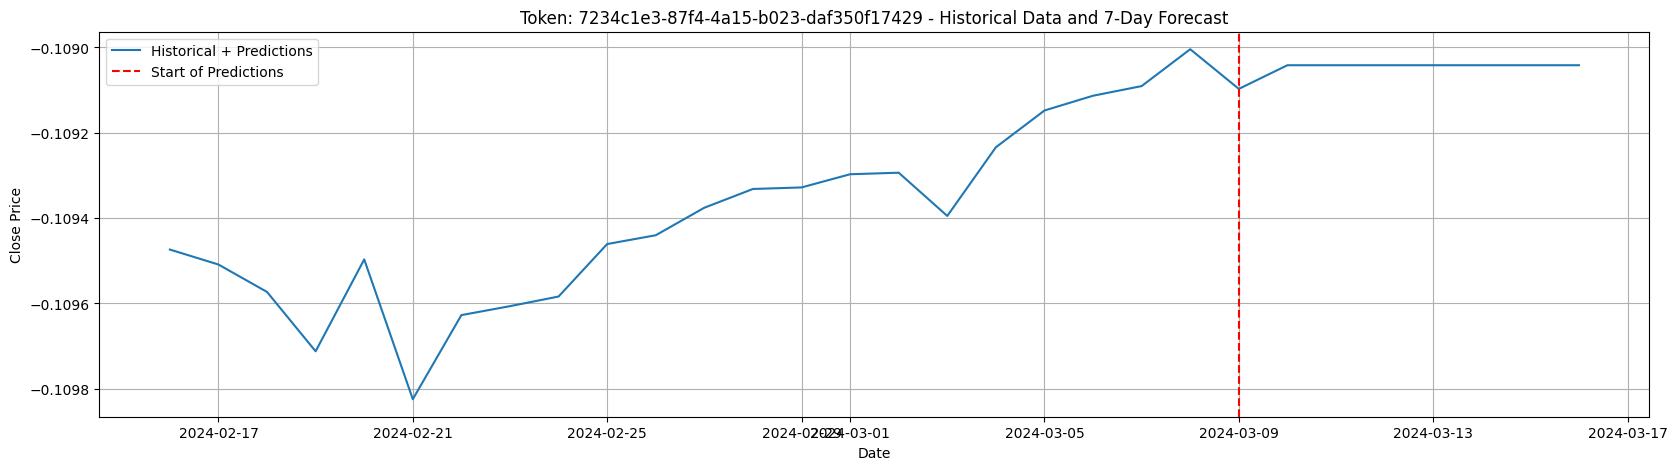

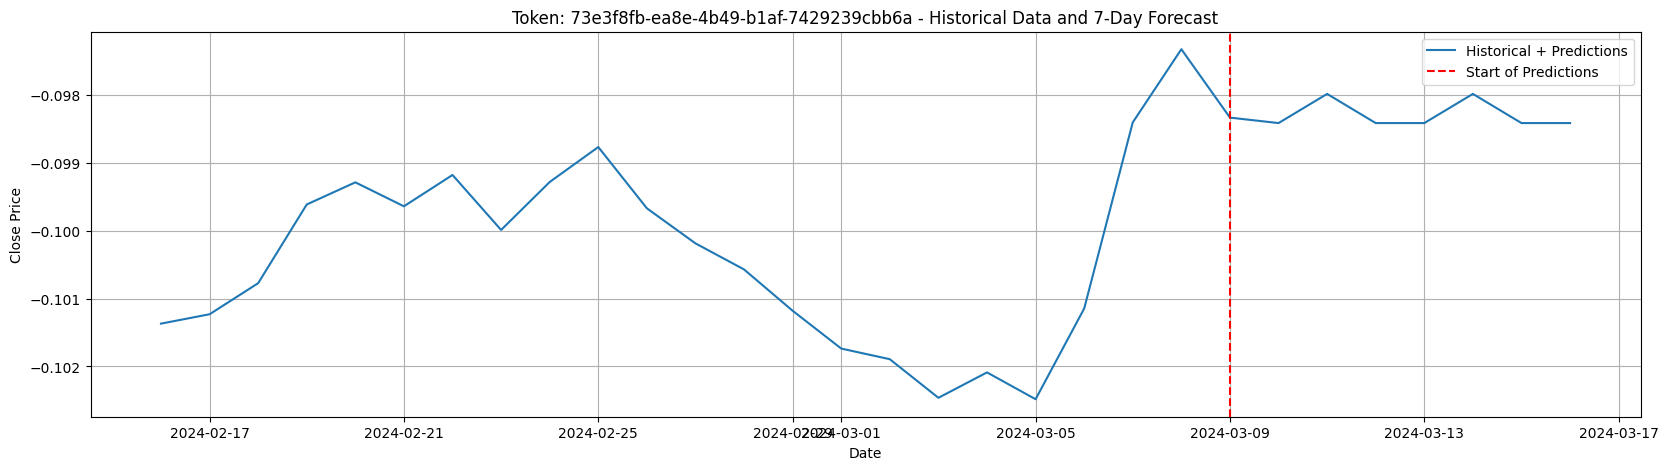

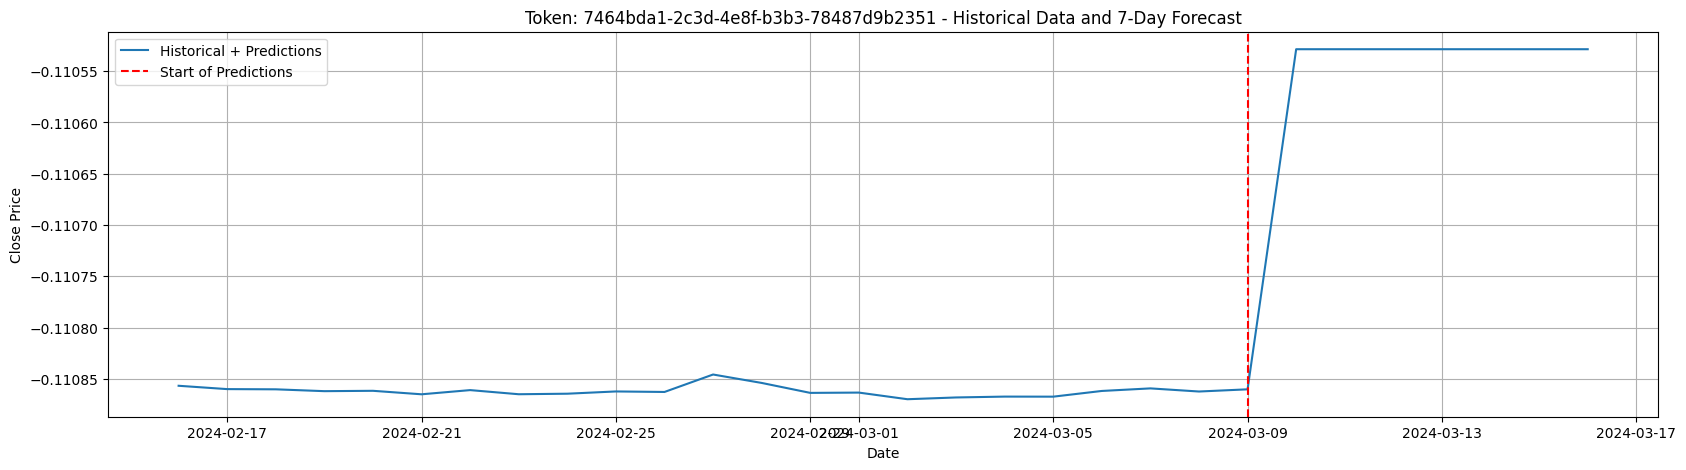

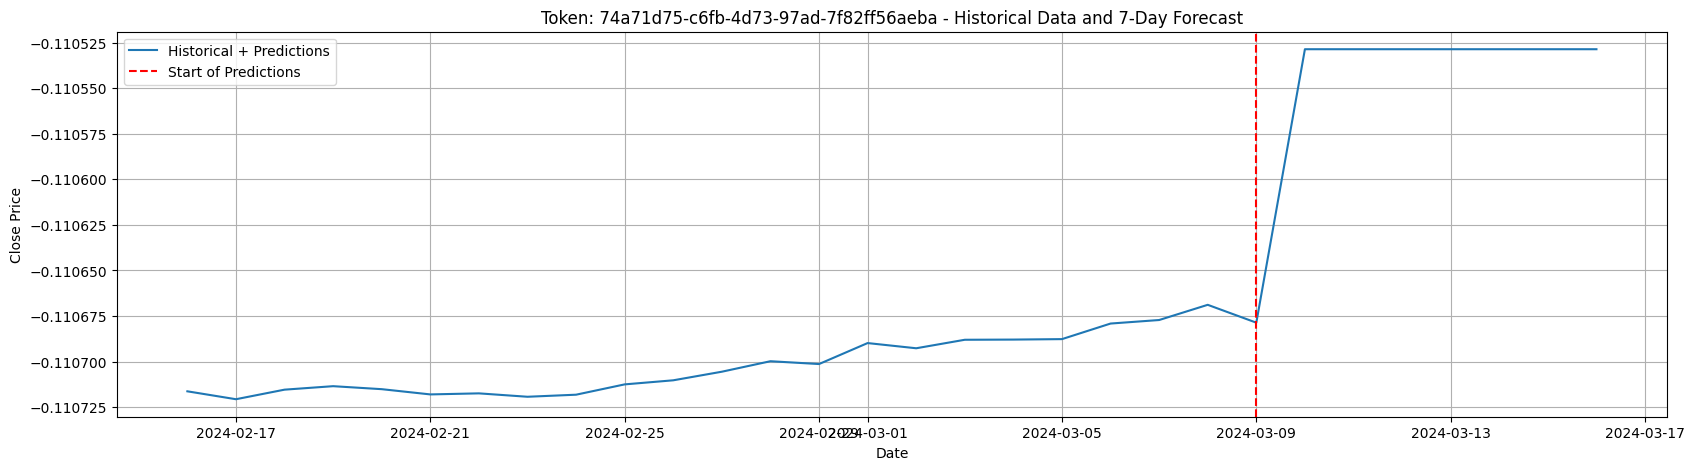

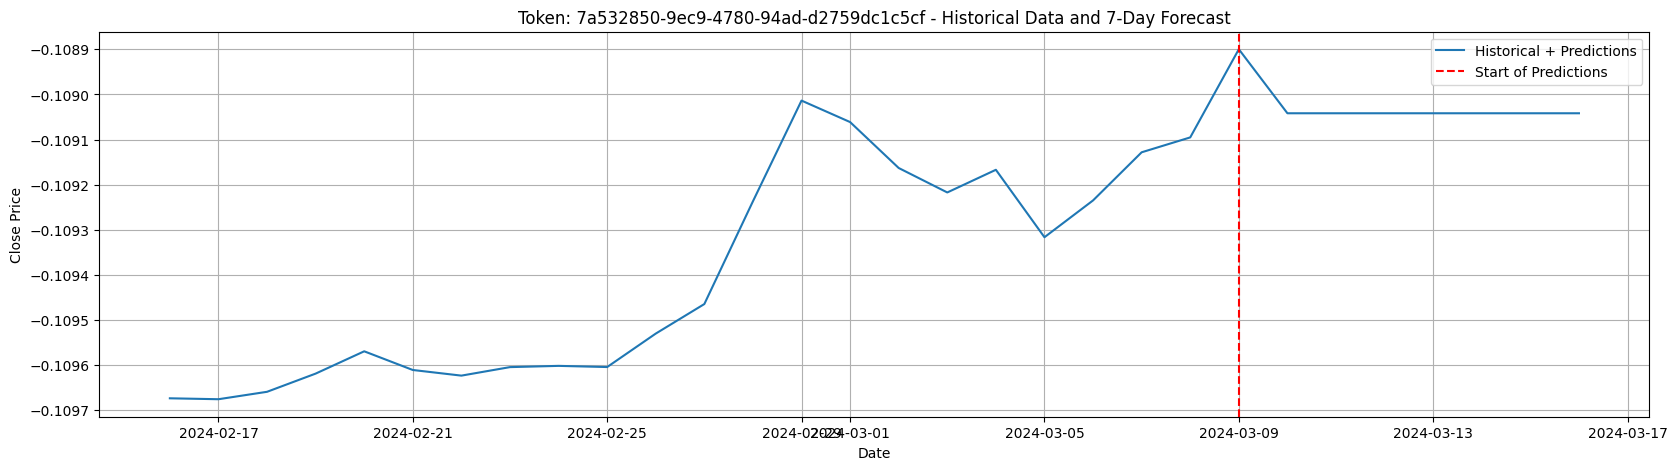

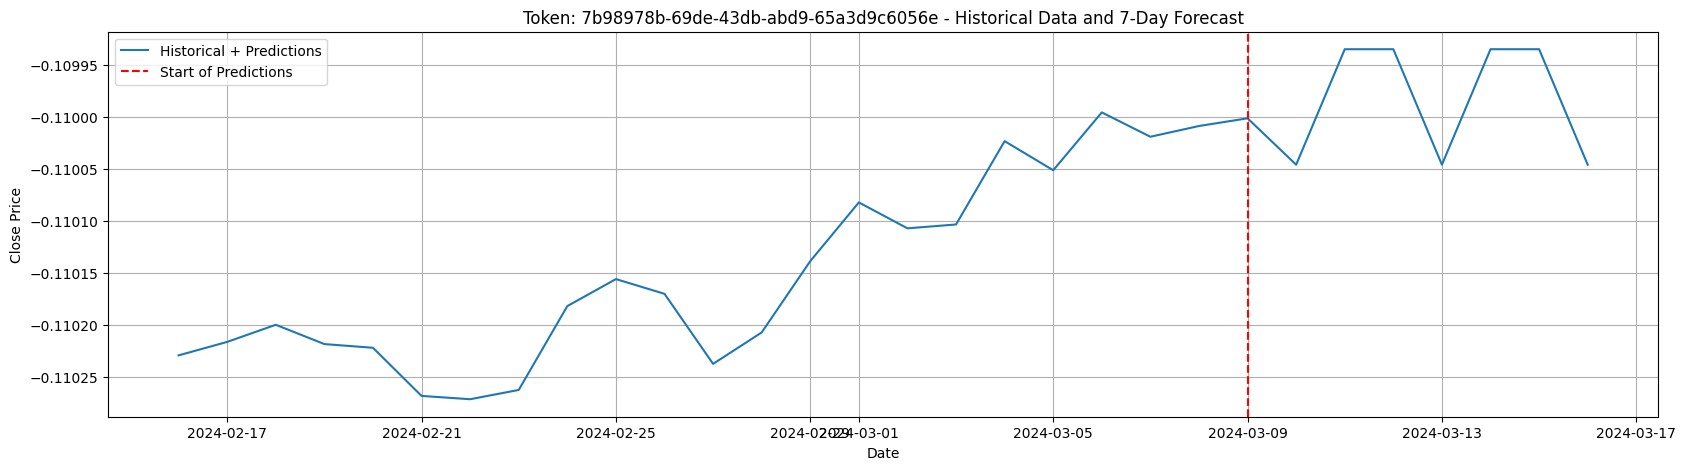

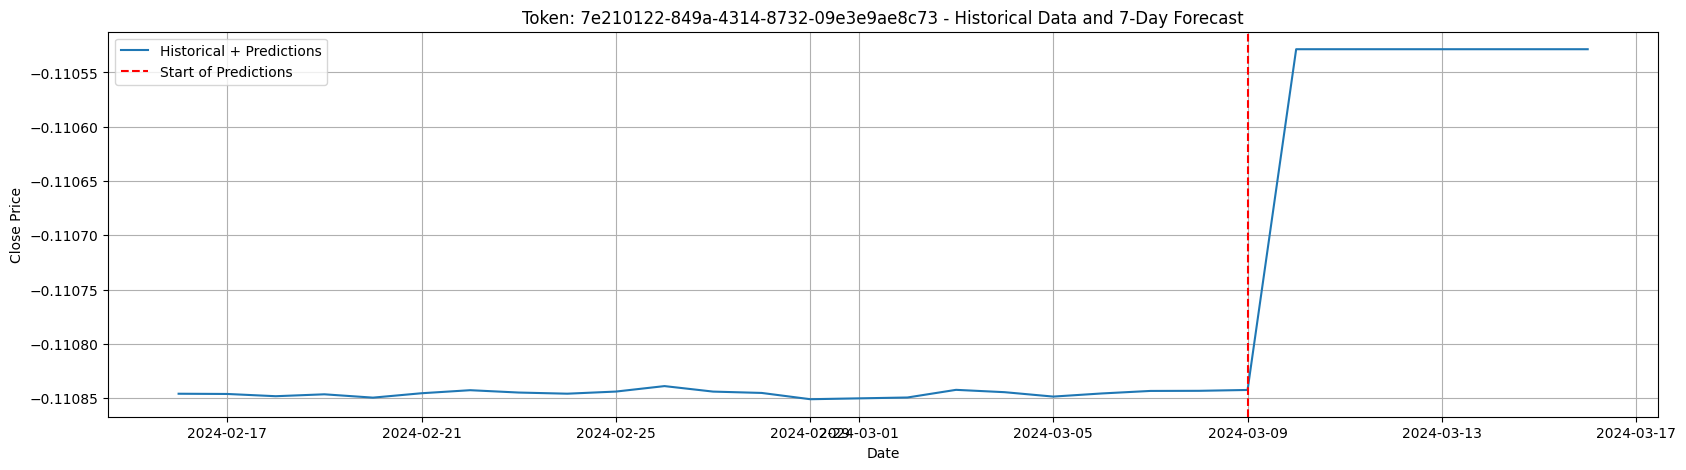

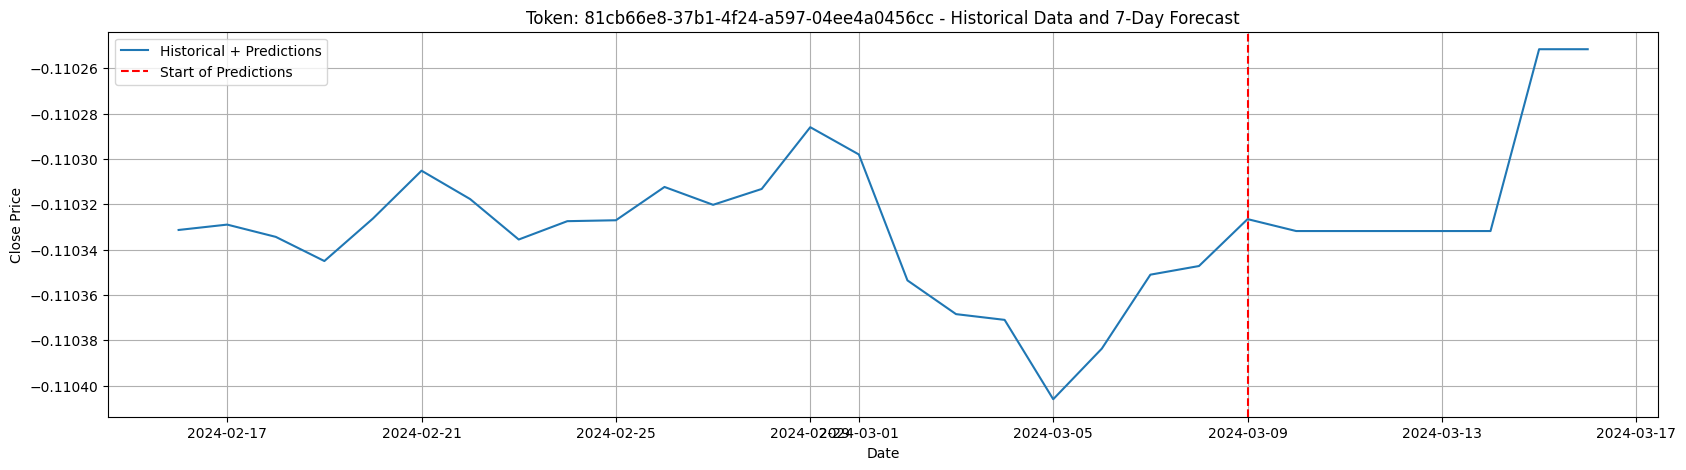

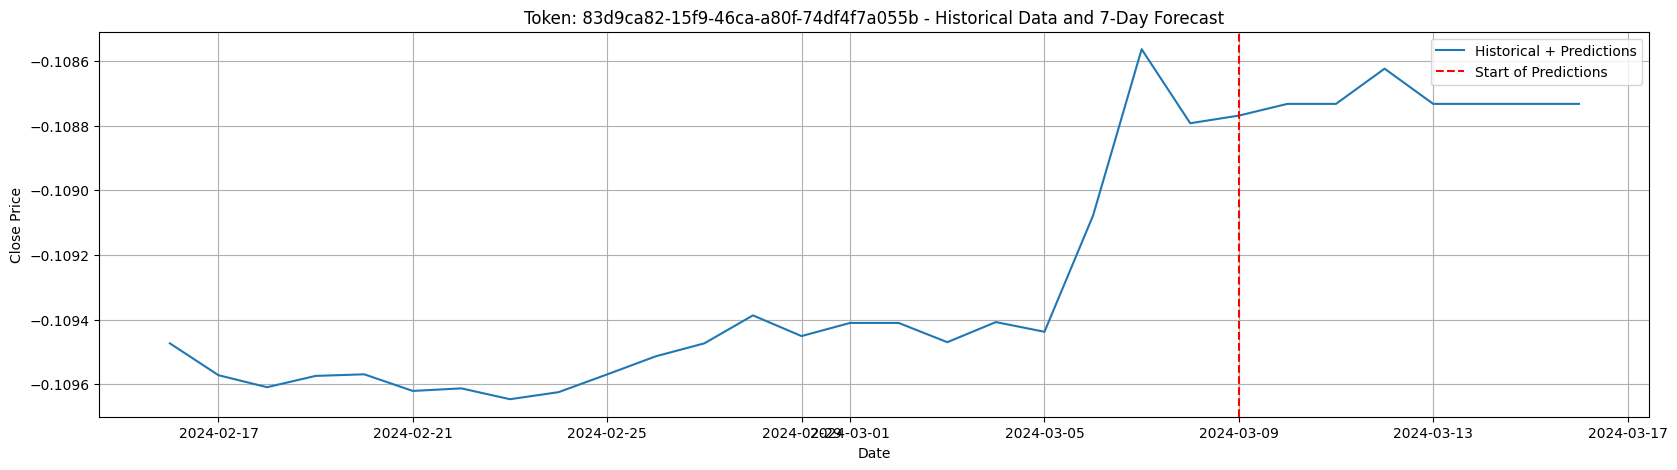

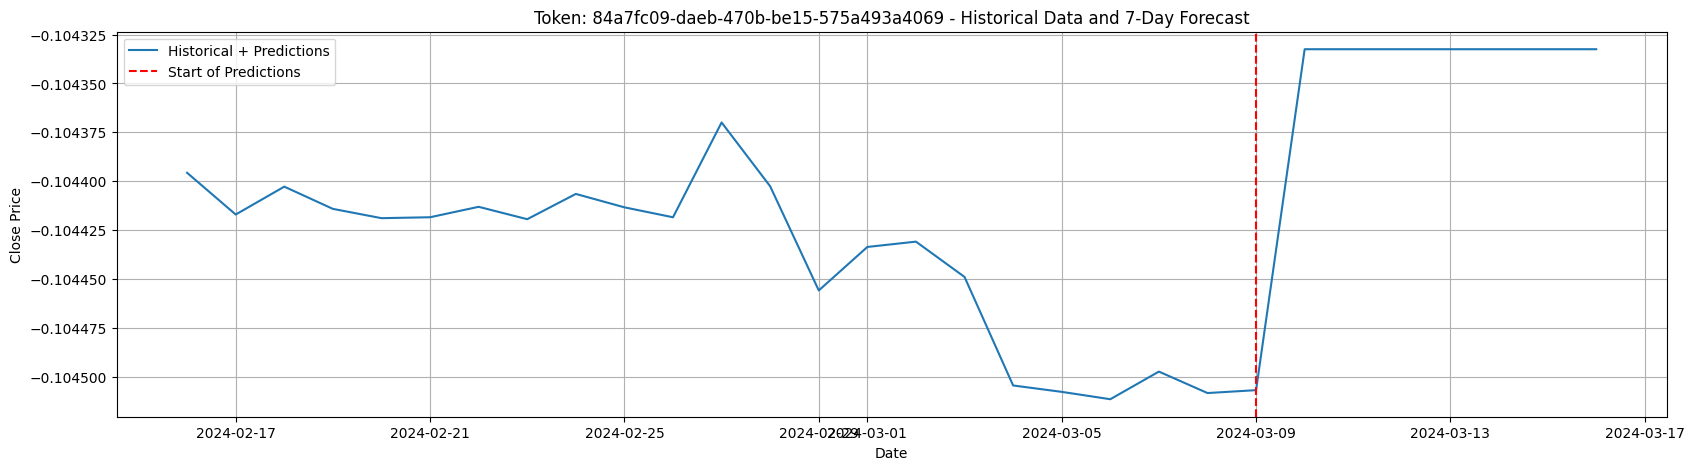

In [29]:
plot_predictions(series_dict, predictions, max_coins=50, last_data_points=30)